In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('bmh')
# %matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['figure.facecolor'] = '#FFFFFF'
from tqdm import tqdm
import os
import random
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
# %load_ext autoreload
# %autoreload 2

# Experiment 1 : 28x28 images (aborted)

# Data Processing and Training Preparation

In [ ]:
# set a random seed to ensure consistent results for each run
SEED = 1023
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [ ]:
# load data
df = pd.read_csv("/content/drive/MyDrive/dpcw/hmnist_28_28_RGB.csv")
df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

Number of classes: 7
Shape of X:  (10015, 2352)
Shape of y:  (10015,)
Number of samples per class:
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


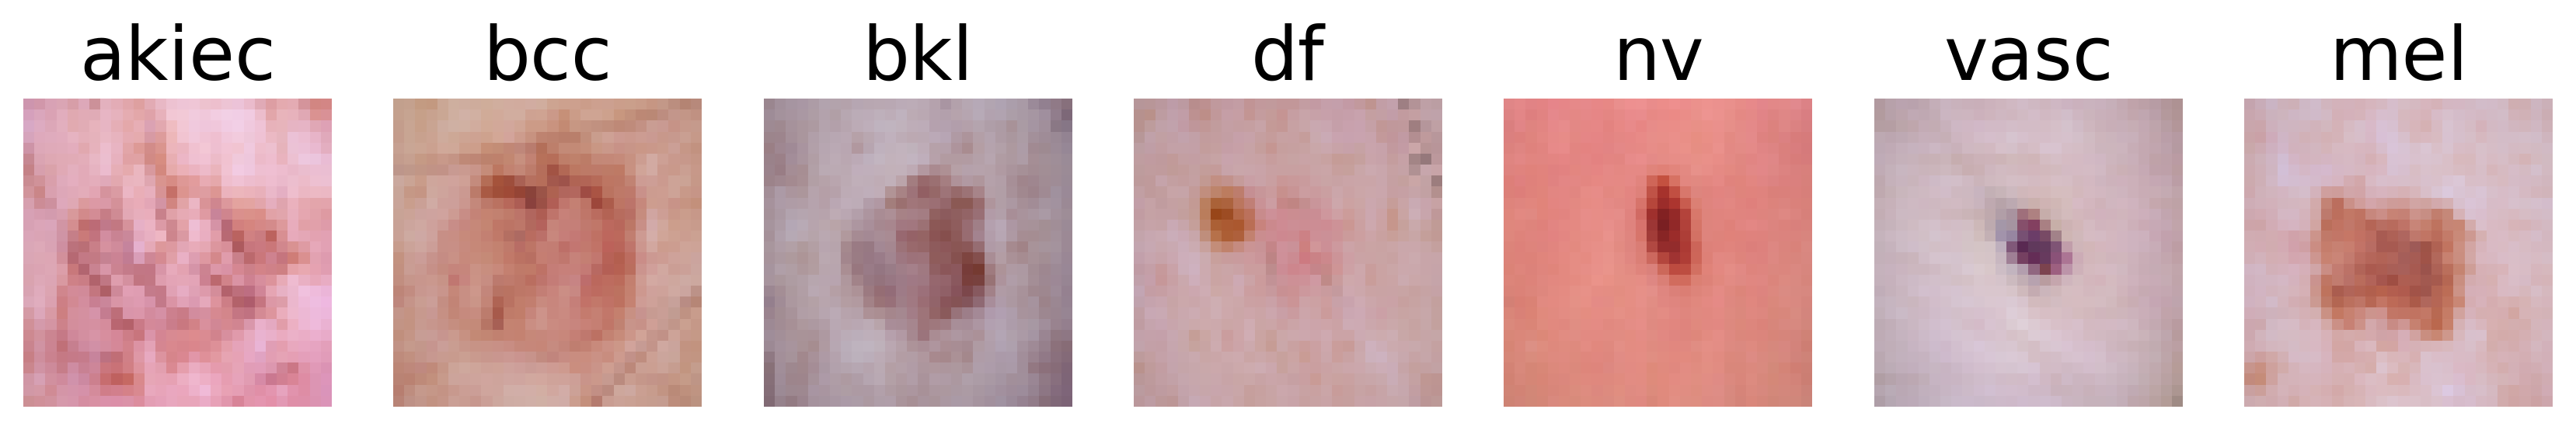

In [ ]:
# pixels of the image: all columns except the last
X = df.iloc[:, :-1].values
# category labels for images: last column
y = df['label'].values
print("Number of classes:",len(np.unique(y)))
classes = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
# statistics on sample size
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
class_counts = df['label'].value_counts()
print("Number of samples per class:")
print(class_counts)
# show some cases
images = X.reshape((-1, 28, 28, 3))
_ = plt.subplots(1, 7, figsize=(14, 2))
np.random.seed(SEED)
for i in range(7):
    _ = plt.subplot(1, 7, i+1)
    _ = plt.imshow(images[np.random.choice(np.arange(len(y))[y==i], 1)].squeeze(0))
    _ = plt.title(classes[i])
    _ = plt.axis("off")
%mkdir figs
plt.savefig("/content/figs/examples.png", dpi=300)
plt.show()

In [ ]:
# manually split training, validation, and test set (0.6-0.2-0.2, random number controlled)
np.random.seed(SEED)
# get indexes
test_idx = np.random.choice(np.arange(len(y)), int(len(y)*0.2), replace=False)
train_idx = np.array([i for i in np.arange(len(y)) if i not in test_idx])
val_idx = np.random.choice(train_idx, int(len(y)*0.2), replace=False)
train_idx = np.array([i for i in train_idx if i not in val_idx])
# apply indexes to dataset
train_X, train_y = images[train_idx], y[train_idx]
val_X, val_y = images[val_idx], y[val_idx]
test_X, test_y = images[test_idx], y[test_idx]
print("Shape of train_X and train_y : ", train_X.shape, train_y.shape)
print("Shape of val_X and val_y : ", val_X.shape, val_y.shape)
print("Shape of test_X and test_y : ", test_X.shape, test_y.shape)

Shape of train_X and train_y :  (6009, 28, 28, 3) (6009,)
Shape of val_X and val_y :  (2003, 28, 28, 3) (2003,)
Shape of test_X and test_y :  (2003, 28, 28, 3) (2003,)


In [ ]:
# count the data ratio of each category in each dataset (check the balance of the data distribution)
cnt_df = pd.DataFrame(np.zeros((len(classes), 4)), columns=['Total', 'Train', 'Val', 'Test'])
for i, data in enumerate([y, train_y, val_y, test_y]):
    for c in range(len(classes)):
        cnt_df.iloc[c, i] = (data==c).sum() / len(data)
print(cnt_df)

      Total     Train       Val      Test
0  0.032651  0.033450  0.029955  0.032951
1  0.051323  0.051922  0.042436  0.058412
2  0.109735  0.112332  0.112332  0.099351
3  0.011483  0.011483  0.011483  0.011483
4  0.669496  0.667998  0.672491  0.670994
5  0.014179  0.013979  0.015477  0.013480
6  0.111133  0.108837  0.115826  0.113330


<Figure size 4800x1500 with 0 Axes>

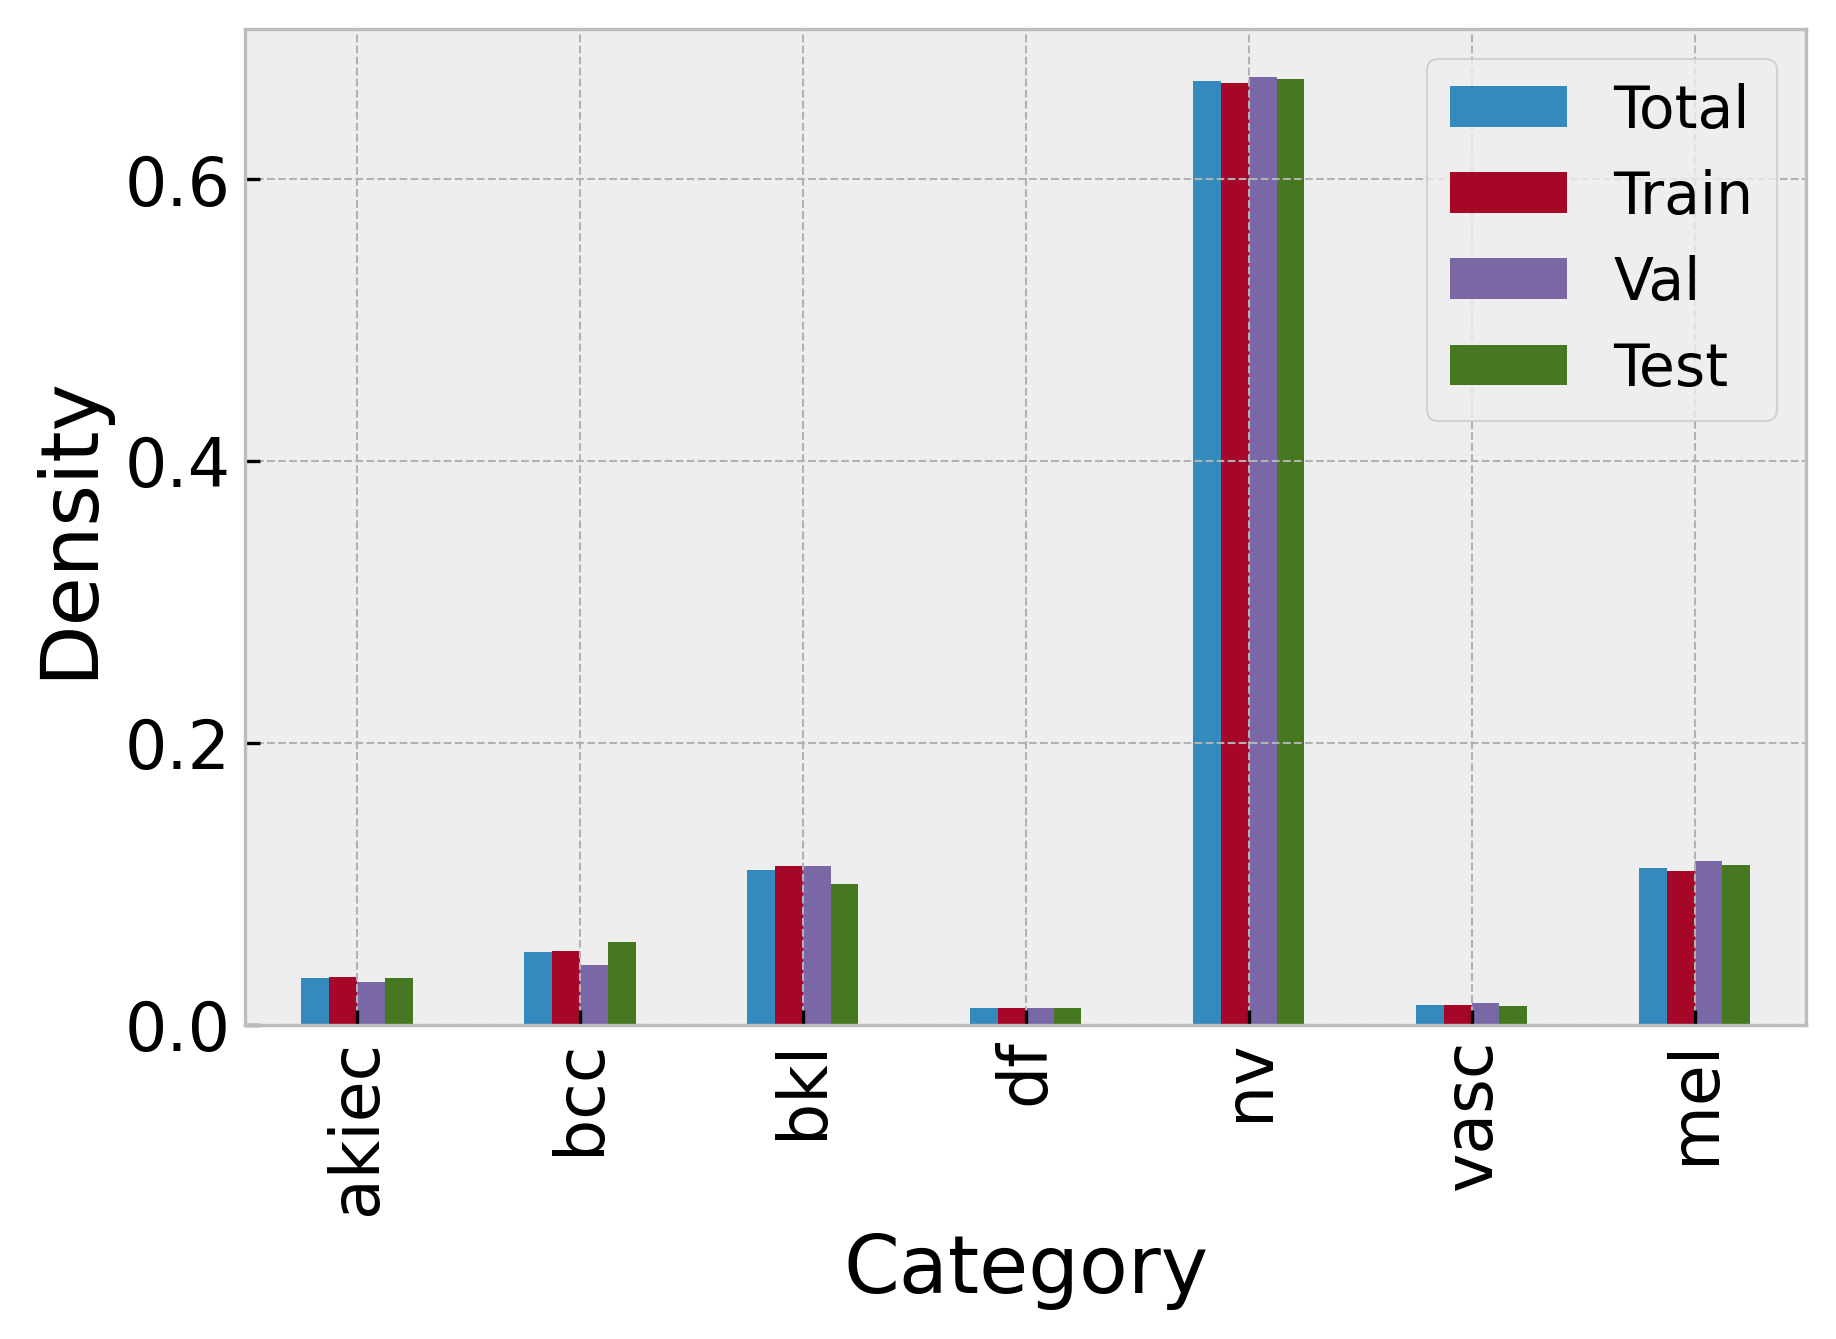

In [ ]:
_ = plt.figure(figsize=(16, 5))
_ = cnt_df.plot(kind='bar')
_ = plt.xticks(np.arange(len(classes)), classes)
_ = plt.xlabel("Category",color='#000000')
_ = plt.ylabel("Density",color='#000000')
plt.tick_params(axis='both', colors='#000000')
plt.tight_layout()
plt.savefig("figs/hist.png", dpi=300)
plt.show()

In [ ]:
# data augmentation
def rotate_nobound(image, scale=1.):
    image = image.astype(np.uint8)
    angle = random.choice([90, 180, 270])
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # affine transformation
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def center_crop(image, size=(14, 14)):
    image = image.astype(np.uint8)
    h, w = image.shape[0:2]
    new_w, new_h = size
    # calculate the coordinates of the upper left corner of the new image in the original image
    x0 = int((w - new_w) / 2)
    y0 = int((h - new_h) / 2)
    out = image[y0:y0 + new_h, x0:x0 + new_w]
    # scale to restore original size (bicubic interpolation on 4x4 pixel neighbour)
    out = cv2.resize(out, (w, h), interpolation=cv2.INTER_CUBIC)
    return out


def random_brightness(image, delta=10):
    rand = np.random.randint(2)
    if rand:
      delta = np.random.uniform(-delta, delta)
      image = (image + delta).clip(0.0, 255.0)
    return image

# mixup
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # randomly sample a probability from a uniform distribution
    else:
        lam = 1
    batch_size = x.shape[0]
    index = np.random.choice(batch_size, batch_size, replace=False) # randomly shuffle the entire index
    mixed_x = lam * x + (1 - lam) * x[index] # mix the image
    y_b = y[index] # keep both labels on y and y_b for criterion
    return mixed_x, y, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) # combine and calculate mixed losses

aug_funcs = [rotate_nobound, center_crop, random_brightness]

# make training data balance
def augment_data(train_img, train_label, max_num=4500): # max_num: the amount of data that each category is ultimately enhanced to
    class_num = len(np.unique(train_label))
    aug_img, aug_label = np.zeros((class_num * max_num, *train_img.shape[1:]), dtype=np.uint8), np.zeros((class_num * max_num))
    # ensure that the enhanced dataset still contains the original dataset
    aug_img[:len(train_img)] = train_img
    aug_label[:len(train_label)] = train_label
    # apply aug functions
    cnt = len(train_label)
    for c in range(class_num):
        for i in tqdm(range(max_num - (train_label==c).sum())):
            idx = np.random.choice(np.where(train_label==c)[0][:len(train_label)])# limit the range no more than original dataset length to avoid multiple enhancements on one image
            aug_fn = random.choice(aug_funcs)
            aug_img[cnt] = aug_fn(train_img[idx])
            aug_label[cnt] = c
            cnt += 1
    return aug_img, aug_label

In [ ]:
# prepare data
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/dpcw')
from resnet import ResNet
from byol import BYOL
from vgg import VGG_A, VGG_D, VGG_D2
from cvae import CVAE

aug = True
device = 'cuda'
if not aug:
    train_X_tensor = torch.FloatTensor(train_X).permute(0, 3, 1, 2).to(device) / 255.0
    train_y_tensor = torch.LongTensor(train_y).to(device)
else:

    train_aug_X, train_aug_y = augment_data(train_X, train_y)
    train_X_tensor = torch.FloatTensor(train_aug_X).permute(0, 3, 1, 2).to(device) / 255.0
    train_y_tensor = torch.LongTensor(train_aug_y).to(device)

val_X_tensor = torch.FloatTensor(val_X).permute(0, 3, 1, 2).to(device) / 255.0
val_y_tensor = torch.LongTensor(val_y).to(device)

test_X_tensor = torch.FloatTensor(test_X).permute(0, 3, 1, 2).to(device) / 255.0
test_y_tensor = torch.LongTensor(test_y).to(device)

print(train_X_tensor.shape)
print(train_y_tensor.shape)
print(val_X_tensor.shape)
print(val_y_tensor.shape)
print(test_X_tensor.shape)
print(test_y_tensor.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 3846/3846 [00:00<00:00, 16986.17it/s]


torch.Size([31500, 3, 28, 28])
torch.Size([31500])
torch.Size([2003, 3, 28, 28])
torch.Size([2003])
torch.Size([2003, 3, 28, 28])
torch.Size([2003])


# VGG

In [ ]:
# initialize
batch_size = 64
epochs = 20
lr = 1e-4
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
layers = 7
hidden_dims_D = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
vgg = VGG_D(len(classes),hidden_dims=hidden_dims_D[:layers]).to(device)
optimizer = torch.optim.Adam(vgg.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Training
vgg_history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss, train_avg_acc = [], 0.0
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        # mixup
        mixed_X, y_a, y_b, lam = mixup_data(batch_X, batch_y)
        output = vgg(mixed_X)

        # train_loss = loss_fn(output, batch_y), but mixup applied here, need to change criterion also
        train_loss = mixup_criterion(loss_fn, output, y_a, y_b, lam)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_avg_loss.append(train_loss.item())
        # train_avg_acc += (output.argmax(dim=1) == batch_y).sum(), but need to calculate weighted acc here
        mixed_preds = output.argmax(dim=1)
        train_avg_acc += (lam * (mixed_preds == y_a).sum() + (1 - lam) * (mixed_preds == y_b).sum())
    train_avg_loss = np.mean(train_avg_loss)
    train_avg_acc /= len(train_X_tensor)

    # evaluation
    val_avg_loss, val_avg_acc = [], 0.0
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            output = vgg(batch_X)
            val_loss = loss_fn(output, batch_y)
            val_avg_loss.append(val_loss.item())
            val_avg_acc += (output.argmax(dim=1) == batch_y).sum()

    val_avg_loss = np.mean(val_avg_loss)
    val_avg_acc /= len(val_X_tensor)
    vgg_history['train_loss'].append(train_avg_loss)
    vgg_history['train_acc'].append(train_avg_acc)
    vgg_history['val_loss'].append(val_avg_loss)
    vgg_history['val_acc'].append(val_avg_acc)
    print("Epoch [{}] | train loss {:.4f} acc {:.4f} | val loss {:.4f} acc {:.4f}".format(epoch, train_avg_loss, train_avg_acc, val_avg_loss, val_avg_acc))

# testing
test_avg_loss, test_avg_acc = [], 0.0
with torch.no_grad():
    for i in range(int(test_X_tensor.shape[0]/batch_size)):
        batch_X = test_X_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        batch_y = test_y_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        output = vgg(batch_X)
        test_loss = loss_fn(output, batch_y)
        test_avg_loss.append(test_loss.item())
        test_avg_acc += (output.argmax(dim=1) == batch_y).sum()
test_avg_loss = np.mean(test_avg_loss)
test_avg_acc /= len(test_X_tensor)
print("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))

Epoch [0] | train loss 1.5383 acc 0.4222 | val loss 1.1373 acc 0.6016
Epoch [1] | train loss 1.3547 acc 0.5183 | val loss 1.1054 acc 0.5896
Epoch [2] | train loss 1.2597 acc 0.5620 | val loss 1.0069 acc 0.6425
Epoch [3] | train loss 1.1817 acc 0.5991 | val loss 1.0933 acc 0.5906
Epoch [4] | train loss 1.1377 acc 0.6231 | val loss 0.8107 acc 0.7119
Epoch [5] | train loss 1.0984 acc 0.6395 | val loss 0.8576 acc 0.6810
Epoch [6] | train loss 1.0940 acc 0.6440 | val loss 0.8866 acc 0.6565
Epoch [7] | train loss 1.0526 acc 0.6633 | val loss 0.8834 acc 0.6735
Epoch [8] | train loss 0.9801 acc 0.6933 | val loss 0.8149 acc 0.6910
Epoch [9] | train loss 0.9731 acc 0.6985 | val loss 0.8884 acc 0.6870
Epoch [10] | train loss 0.9709 acc 0.6972 | val loss 0.8577 acc 0.6945
Epoch [11] | train loss 0.9439 acc 0.7107 | val loss 0.9376 acc 0.6705
Epoch [12] | train loss 0.9522 acc 0.7017 | val loss 0.7722 acc 0.7219
Epoch [13] | train loss 0.9269 acc 0.7177 | val loss 0.7680 acc 0.7319
Epoch [14] | tra

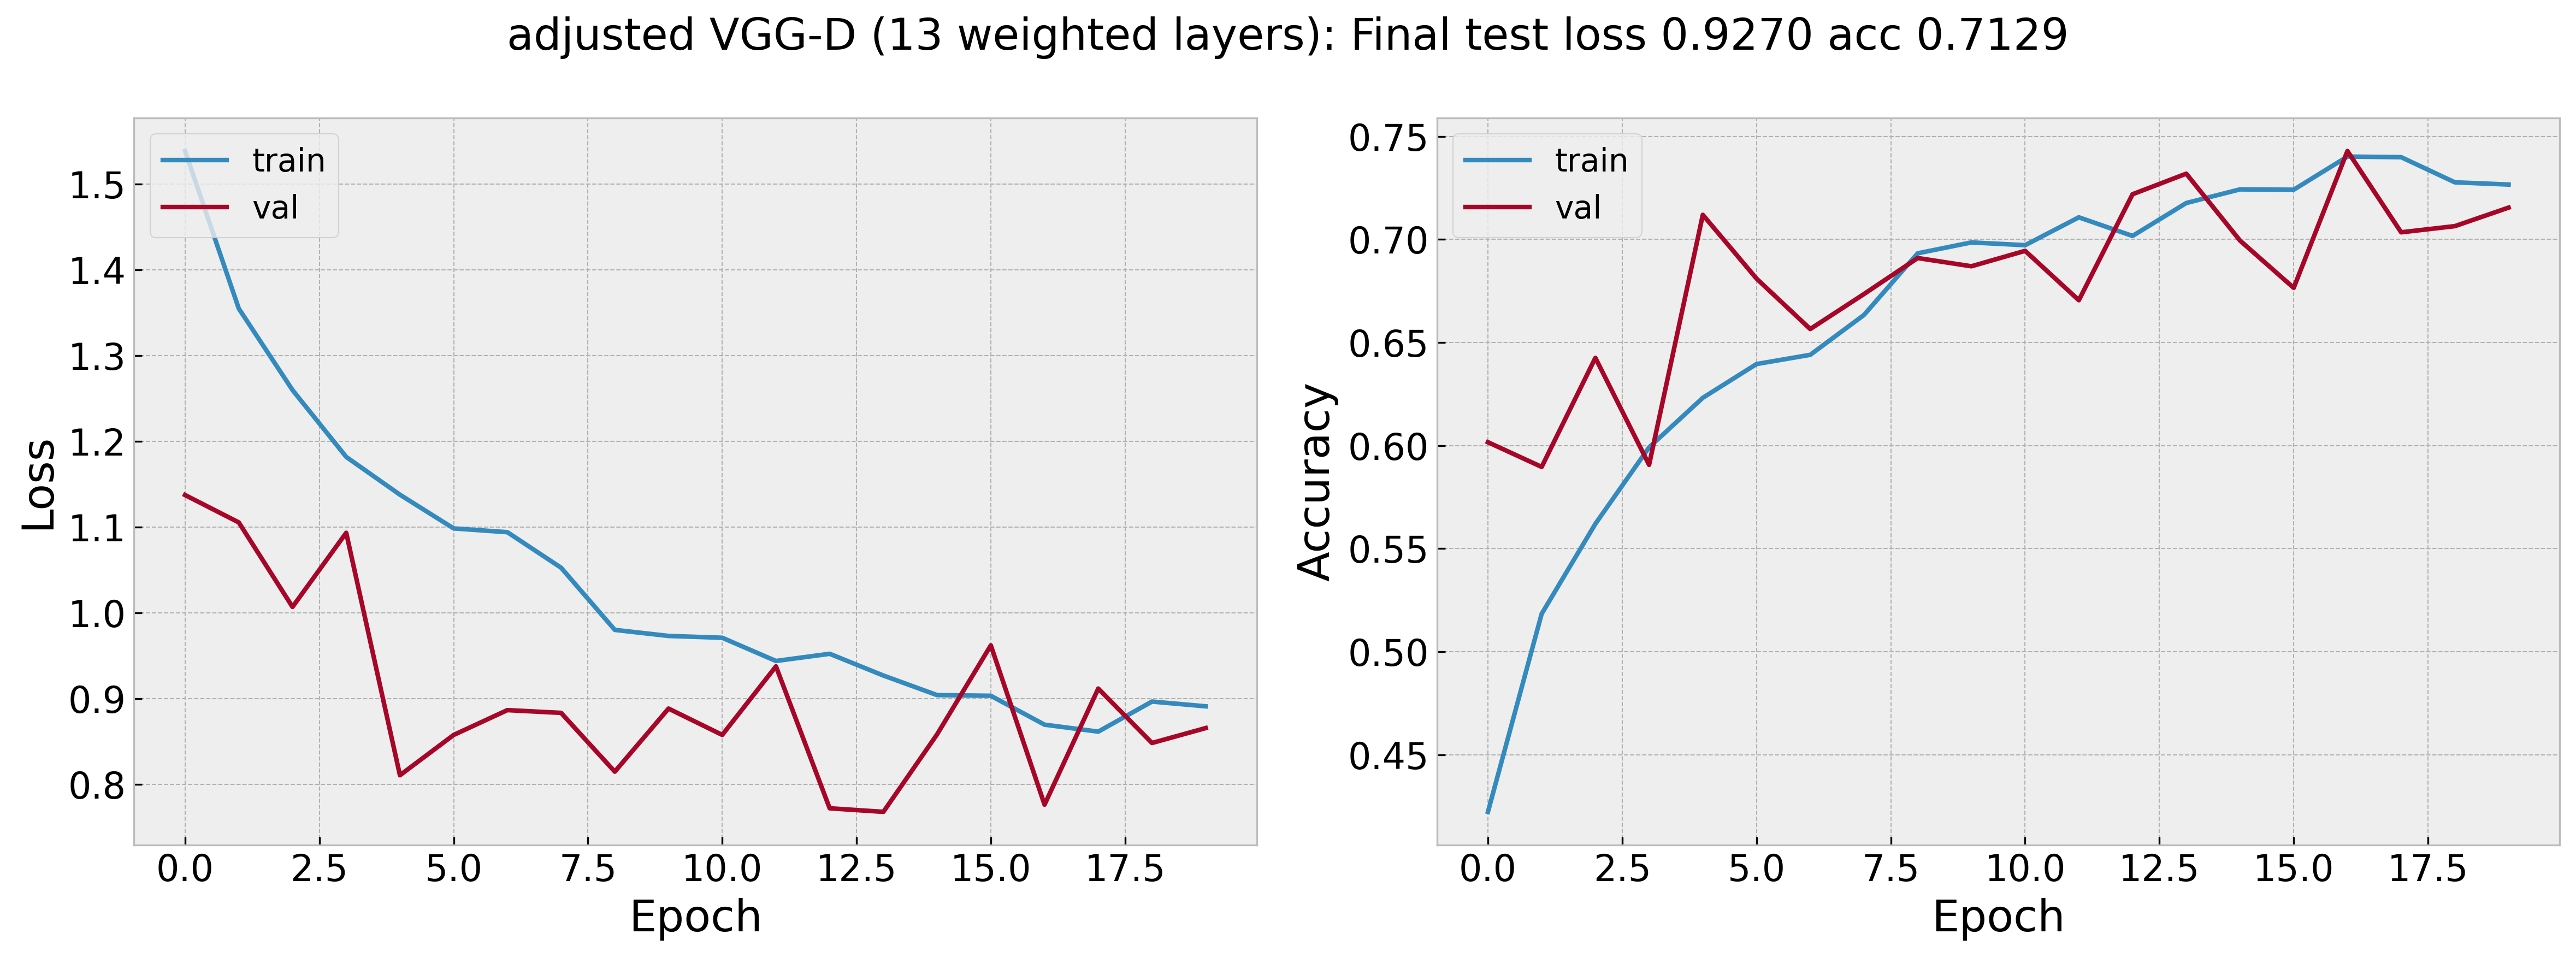

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(vgg_history['train_loss'], label='train')
_ = plt.plot(vgg_history['val_loss'], label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)
train_acc_numbers = [acc.item() for acc in vgg_history['train_acc']]
val_acc_numbers = [acc.item() for acc in vgg_history['val_acc']]
_ = plt.plot(train_acc_numbers, label='train')
_ = plt.plot(val_acc_numbers, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("adjusted VGG-D (13 weighted layers): Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))
plt.tight_layout()
plt.savefig("figs/vgg{}_train_{}.png".format(layers+3, 'aug' if aug else ''), dpi=300)
plt.show()

In [ ]:
# initialize
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
layers = 13
hidden_dims_D = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
vgg = VGG_D2(len(classes),hidden_dims=hidden_dims_D[:layers]).to(device)
optimizer = torch.optim.Adam(vgg.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Training
vgg_history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss, train_avg_acc = [], 0.0
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        # mixup
        mixed_X, y_a, y_b, lam = mixup_data(batch_X, batch_y)
        output = vgg(mixed_X)

        # train_loss = loss_fn(output, batch_y), but mixup applied here, need to change criterion also
        train_loss = mixup_criterion(loss_fn, output, y_a, y_b, lam)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_avg_loss.append(train_loss.item())
        # train_avg_acc += (output.argmax(dim=1) == batch_y).sum(), but need to calculate weighted acc here
        mixed_preds = output.argmax(dim=1)
        train_avg_acc += (lam * (mixed_preds == y_a).sum() + (1 - lam) * (mixed_preds == y_b).sum())
    train_avg_loss = np.mean(train_avg_loss)
    train_avg_acc /= len(train_X_tensor)

    # evaluation
    val_avg_loss, val_avg_acc = [], 0.0
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            output = vgg(batch_X)
            val_loss = loss_fn(output, batch_y)
            val_avg_loss.append(val_loss.item())
            val_avg_acc += (output.argmax(dim=1) == batch_y).sum()

    val_avg_loss = np.mean(val_avg_loss)
    val_avg_acc /= len(val_X_tensor)
    vgg_history['train_loss'].append(train_avg_loss)
    vgg_history['train_acc'].append(train_avg_acc)
    vgg_history['val_loss'].append(val_avg_loss)
    vgg_history['val_acc'].append(val_avg_acc)
    print("Epoch [{}] | train loss {:.4f} acc {:.4f} | val loss {:.4f} acc {:.4f}".format(epoch, train_avg_loss, train_avg_acc, val_avg_loss, val_avg_acc))

# testing
test_avg_loss, test_avg_acc = [], 0.0
with torch.no_grad():
    for i in range(int(test_X_tensor.shape[0]/batch_size)):
        batch_X = test_X_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        batch_y = test_y_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        output = vgg(batch_X)
        test_loss = loss_fn(output, batch_y)
        test_avg_loss.append(test_loss.item())
        test_avg_acc += (output.argmax(dim=1) == batch_y).sum()
test_avg_loss = np.mean(test_avg_loss)
test_avg_acc /= len(test_X_tensor)
print("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))

Epoch [0] | train loss 1.5560 acc 0.4173 | val loss 1.5412 acc 0.4738
Epoch [1] | train loss 1.3456 acc 0.5379 | val loss 1.5483 acc 0.4443
Epoch [2] | train loss 1.2341 acc 0.5912 | val loss 1.4537 acc 0.4888
Epoch [3] | train loss 1.1475 acc 0.6291 | val loss 1.7041 acc 0.3909
Epoch [4] | train loss 1.0948 acc 0.6541 | val loss 1.2090 acc 0.5731
Epoch [5] | train loss 1.0436 acc 0.6740 | val loss 1.2453 acc 0.5786
Epoch [6] | train loss 1.0332 acc 0.6767 | val loss 1.2315 acc 0.5657
Epoch [7] | train loss 0.9915 acc 0.6957 | val loss 1.0541 acc 0.6550
Epoch [8] | train loss 0.9168 acc 0.7235 | val loss 1.1182 acc 0.6271
Epoch [9] | train loss 0.9119 acc 0.7251 | val loss 1.1125 acc 0.6286
Epoch [10] | train loss 0.9122 acc 0.7233 | val loss 1.1736 acc 0.6206
Epoch [11] | train loss 0.8905 acc 0.7339 | val loss 1.1694 acc 0.5956
Epoch [12] | train loss 0.8963 acc 0.7244 | val loss 0.9773 acc 0.6875
Epoch [13] | train loss 0.8740 acc 0.7371 | val loss 1.0598 acc 0.6535
Epoch [14] | tra

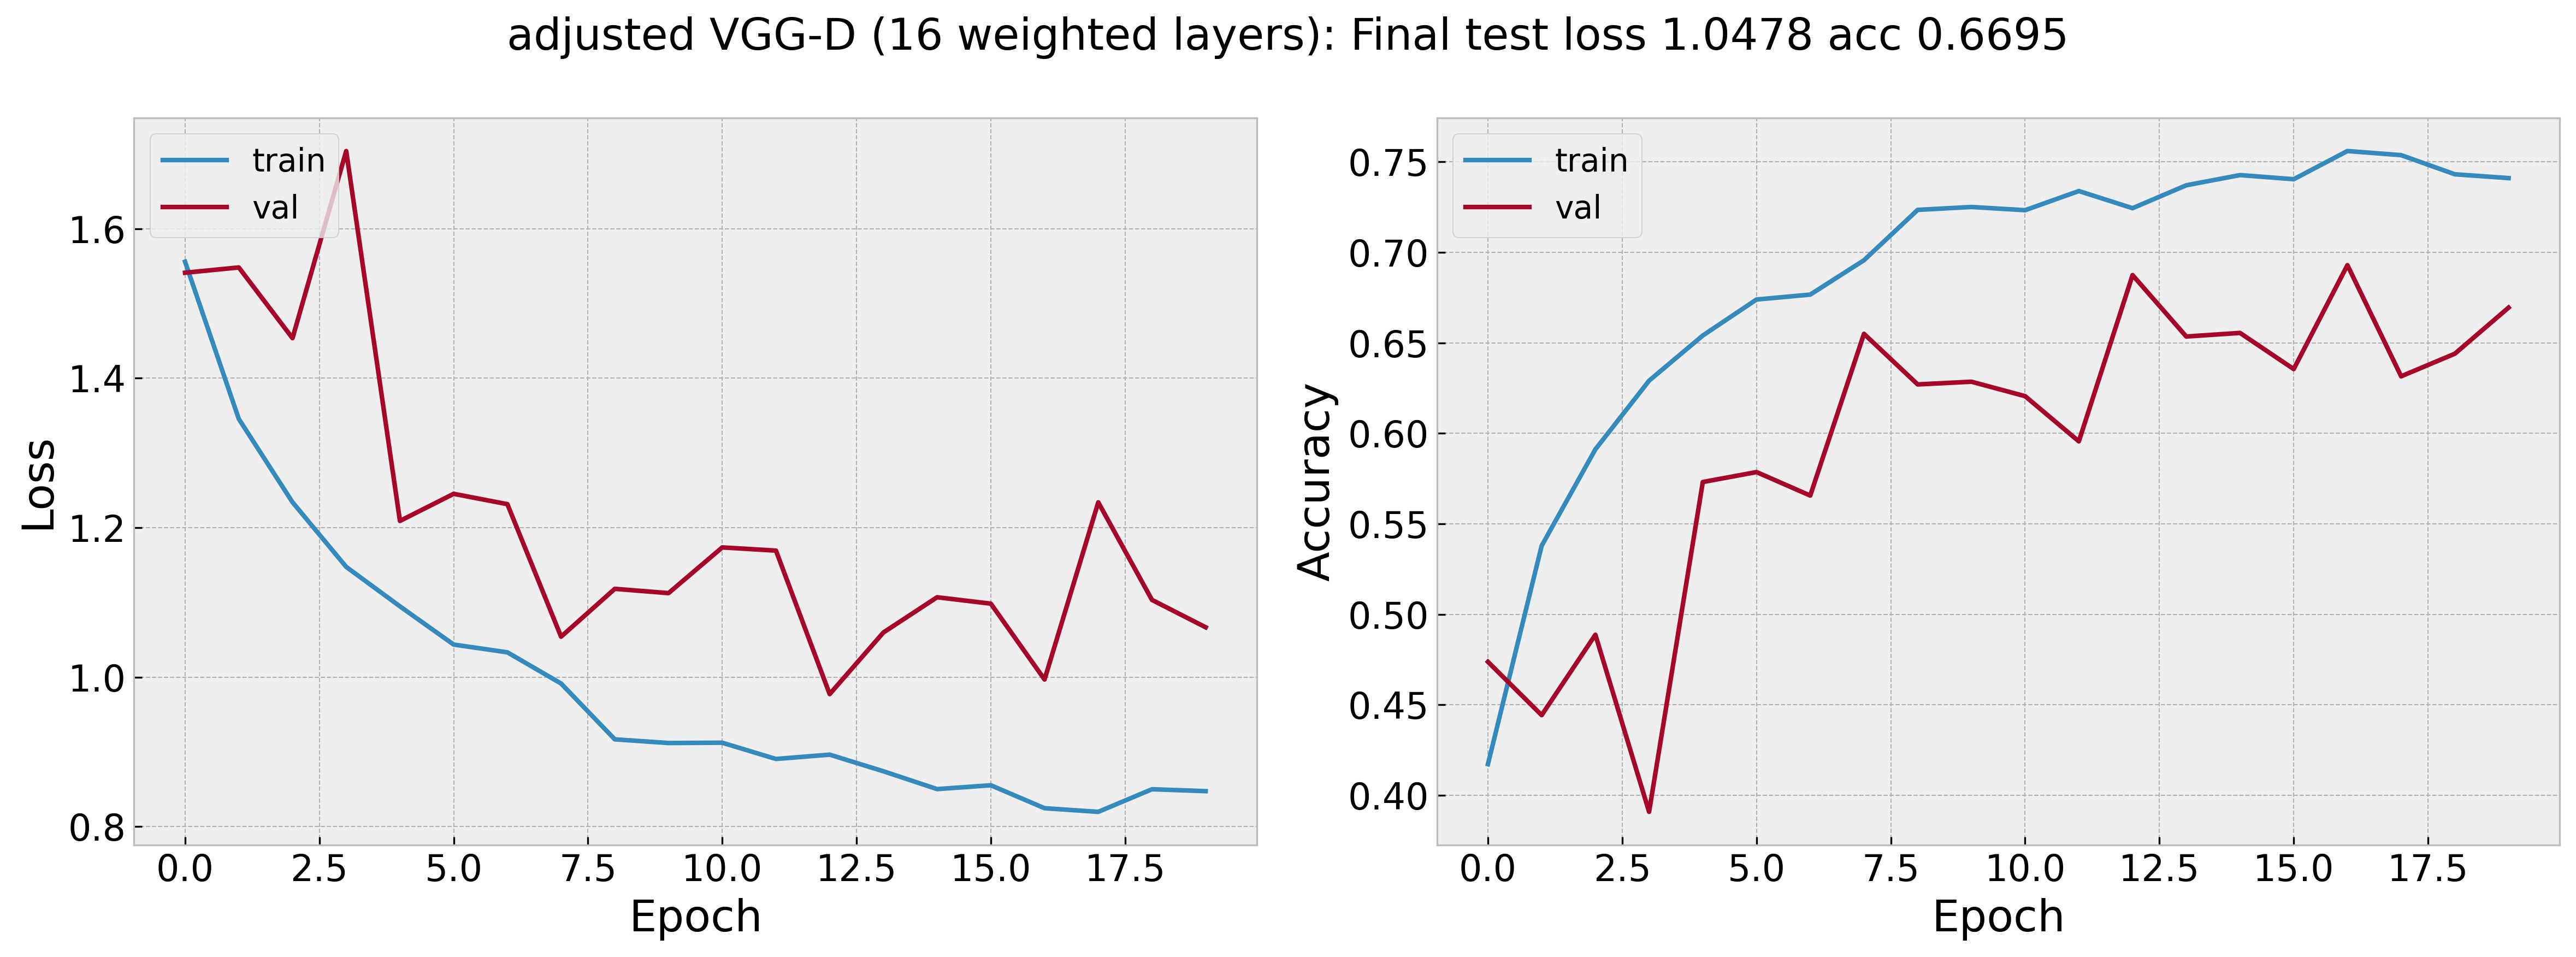

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(vgg_history['train_loss'], label='train')
_ = plt.plot(vgg_history['val_loss'], label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)
train_acc_numbers = [acc.item() for acc in vgg_history['train_acc']]
val_acc_numbers = [acc.item() for acc in vgg_history['val_acc']]
_ = plt.plot(train_acc_numbers, label='train')
_ = plt.plot(val_acc_numbers, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("adjusted VGG-D (16 weighted layers): Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))
plt.tight_layout()
plt.savefig("figs/vgg{}_train_{}.png".format(layers+3, 'aug' if aug else ''), dpi=300)
plt.show()

# ResNet

In [ ]:
# Training

pretrained = False
resnet = ResNet(len(classes), pretrained).to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

resnet_history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss, train_avg_acc = [], 0.0
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        output = resnet(batch_X)
        train_loss = loss_fn(output, batch_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_avg_loss.append(train_loss.item())
        train_avg_acc += (output.argmax(dim=1) == batch_y).sum()
    train_avg_loss = np.mean(train_avg_loss)
    train_avg_acc /= len(train_X_tensor)
    # evaluation
    val_avg_loss, val_avg_acc = [], 0.0
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            output = resnet(batch_X)
            val_loss = loss_fn(output, batch_y)
            val_avg_loss.append(val_loss.item())
            val_avg_acc += (output.argmax(dim=1) == batch_y).sum()
    val_avg_loss = np.mean(val_avg_loss)
    val_avg_acc /= len(val_X_tensor)
    resnet_history['train_loss'].append(train_avg_loss)
    resnet_history['train_acc'].append(train_avg_acc)
    resnet_history['val_loss'].append(val_avg_loss)
    resnet_history['val_acc'].append(val_avg_acc)
    print("Epoch [{}] | train loss {:.4f} acc {:.4f} | val loss {:.4f} acc {:.4f}".format(epoch, train_avg_loss, train_avg_acc, val_avg_loss, val_avg_acc))

# testing
test_avg_loss, test_avg_acc = [], 0.0
with torch.no_grad():
    for i in range(int(test_X_tensor.shape[0]/batch_size)):
        batch_X = test_X_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        batch_y = test_y_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        output = resnet(batch_X)
        test_loss = loss_fn(output, batch_y)
        test_avg_loss.append(test_loss.item())
        test_avg_acc += (output.argmax(dim=1) == batch_y).sum()
test_avg_loss = np.mean(test_avg_loss)
test_avg_acc /= len(test_X_tensor)
print("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))

# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(resnet_history['train_loss'], label='train')
_ = plt.plot(resnet_history['val_loss'], label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)
_ = plt.plot(resnet_history['train_acc'], label='train')
_ = plt.plot(resnet_history['val_acc'], label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))
plt.tight_layout()
plt.savefig("figs/resnet_pretrained-{}_train_{}.png".format(pretrained, 'aug' if aug else ''), dpi=300)
plt.show()

# BYOL + MLP

In [ ]:
layers = 4
lr = 3e-4
pre_epochs = 50
hidden_dims = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
byol_net = BYOL(output_dim=len(classes), hidden_dims=hidden_dims[:layers]).to(device)

byol_history = {'train_byol_loss':[], 'train_loss':[], 'train_acc':[], 'val_byol_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(pre_epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss = []
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        train_loss = byol_net.training_step(batch_X)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        byol_net.update_moving_average()
        train_avg_loss.append(train_loss.item())
    train_avg_loss = np.mean(train_avg_loss)
    # evaluation
    val_avg_loss = []
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            val_loss = byol_net.training_step(batch_X)
            val_avg_loss.append(val_loss.item())
    val_avg_loss = np.mean(val_avg_loss)
    byol_history['train_byol_loss'].append(train_avg_loss)
    byol_history['val_byol_loss'].append(val_avg_loss)
    print("Epoch [{}] | train byol loss {:.4f} | val byol loss {:.4f}".format(epoch, train_avg_loss, val_avg_loss))

optimizer = torch.optim.Adam(byol_net.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss, train_avg_acc = [], 0.0
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        output = byol_net.classify(batch_X)
        train_loss = loss_fn(output, batch_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_avg_loss.append(train_loss.item())
        train_avg_acc += (output.argmax(dim=1) == batch_y).sum()
    train_avg_loss = np.mean(train_avg_loss)
    train_avg_acc /= len(train_X_tensor)
    # evaluation
    val_avg_loss, val_avg_acc = [], 0.0
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            output = byol_net.classify(batch_X)
            val_loss = loss_fn(output, batch_y)
            val_avg_loss.append(val_loss.item())
            val_avg_acc += (output.argmax(dim=1) == batch_y).sum()
    val_avg_loss = np.mean(val_avg_loss)
    val_avg_acc /= len(val_X_tensor)
    byol_history['train_loss'].append(train_avg_loss)
    byol_history['train_acc'].append(train_avg_acc)
    byol_history['val_loss'].append(val_avg_loss)
    byol_history['val_acc'].append(val_avg_acc)
    print("Epoch [{}] | train loss {:.4f} acc {:.4f} | val loss {:.4f} acc {:.4f}".format(epoch, train_avg_loss, train_avg_acc, val_avg_loss, val_avg_acc))

# testing
test_avg_loss, test_avg_acc = [], 0.0
with torch.no_grad():
    for i in range(int(test_X_tensor.shape[0]/batch_size)):
        batch_X = test_X_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        batch_y = test_y_tensor[i*batch_size:min((i+1)*batch_size, test_X_tensor.shape[0])]
        output = byol_net.classify(batch_X)
        test_loss = loss_fn(output, batch_y)
        test_avg_loss.append(test_loss.item())
        test_avg_acc += (output.argmax(dim=1) == batch_y).sum()
test_avg_loss = np.mean(test_avg_loss)
test_avg_acc /= len(test_X_tensor)
print("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))

# CVAE(convolutional)

In [ ]:
# pretrain
pre_epochs = 50
cvae_net = CVAE(output_dim=len(classes)).to(device)
optimizer = torch.optim.Adam(cvae_net.parameters(), lr=lr)

cvae_history = {'train_cvae_loss':[], 'train_loss':[], 'train_acc':[], 'val_cvae_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(pre_epochs):
    shuffle_idx = np.random.choice(train_X_tensor.shape[0], train_X_tensor.shape[0], replace=False)
    # training
    train_avg_loss = []
    for i in range(int(train_X_tensor.shape[0]/batch_size)):
        batch_X = train_X_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        batch_y = train_y_tensor[shuffle_idx[i*batch_size:min((i+1)*batch_size, train_X_tensor.shape[0])]]
        recons, mu, log_var = cvae_net(batch_X, batch_y)
        train_loss = cvae_net.loss_function(recons, batch_X, mu, log_var, 1.0)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_avg_loss.append(train_loss.item())
    train_avg_loss = np.mean(train_avg_loss)
    # evaluation
    val_avg_loss = []
    with torch.no_grad():
        for i in range(int(val_X_tensor.shape[0]/batch_size)):
            batch_X = val_X_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            batch_y = val_y_tensor[i*batch_size:min((i+1)*batch_size, val_X_tensor.shape[0])]
            recons, mu, log_var = cvae_net(batch_X, batch_y)
            val_loss = cvae_net.loss_function(recons, batch_X, mu, log_var, 1.0)
            val_avg_loss.append(val_loss.item())
    val_avg_loss = np.mean(val_avg_loss)
    cvae_history['train_cvae_loss'].append(train_avg_loss)
    cvae_history['val_cvae_loss'].append(val_avg_loss)
    print("Epoch [{}] | train cvae loss {:.4f} | val cvae loss {:.4f}".format(epoch, train_avg_loss, val_avg_loss))

# T-SNE and Comparison of Performance

In [ ]:
_ = plt.subplots(2, 2, figsize=(24, 20))
_ = plt.subplot(2, 2, 1)
vgg_reprs = vgg.get_reprs(test_X_tensor).detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=1, random_state=SEED)
z = tsne.fit_transform(vgg_reprs)
df = pd.DataFrame(np.concatenate([test_y.reshape((-1, 1)), z], axis=1), columns=['y', 'x1', 'x2'])
df['classes'] = df['y'].apply(lambda x: classes[int(x)])
_ = sns.scatterplot(x="x1", y="x2", hue=df.classes.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="VGG")

_ = plt.subplot(2, 2, 2)
resnet_reprs = resnet.get_reprs(test_X_tensor).detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=1, random_state=SEED)
z = tsne.fit_transform(resnet_reprs)
df = pd.DataFrame(np.concatenate([test_y.reshape((-1, 1)), z], axis=1), columns=['y', 'x1', 'x2'])
df['classes'] = df['y'].apply(lambda x: classes[int(x)])
_ = sns.scatterplot(x="x1", y="x2", hue=df.classes.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="ResNet")

_ = plt.subplot(2, 2, 3)
byol_reprs = byol_net(test_X_tensor).detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=1, random_state=SEED)
z = tsne.fit_transform(byol_reprs)
df = pd.DataFrame(np.concatenate([test_y.reshape((-1, 1)), z], axis=1), columns=['y', 'x1', 'x2'])
df['classes'] = df['y'].apply(lambda x: classes[int(x)])
_ = sns.scatterplot(x="x1", y="x2", hue=df.classes.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="BYOL")

_ = plt.subplot(2, 2, 4)
_, cvae_reprs, _ = cvae_net(test_X_tensor, test_y_tensor)
cvae_reprs = cvae_reprs.detach().cpu().numpy()
tsne = TSNE(n_components=2, verbose=1, random_state=SEED)
z = tsne.fit_transform(cvae_reprs)
df = pd.DataFrame(np.concatenate([test_y.reshape((-1, 1)), z], axis=1), columns=['y', 'x1', 'x2'])
df['classes'] = df['y'].apply(lambda x: classes[int(x)])
_ = sns.scatterplot(x="x1", y="x2", hue=df.classes.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="CVAE")

plt.tight_layout()
plt.savefig("figs/tsne.png", dpi=300)

In [ ]:
# ploting
colors = ['#348abd', '#a60628', '#7a68a6', '#467821', '#d55e00', '#cc79a7', '#9ACD32']
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(vgg_history['train_loss'], label='VGG', color=colors[0])
_ = plt.plot(vgg_history['val_loss'], '-.', color=colors[0])
_ = plt.plot(resnet_history['train_loss'], label='ResNet', color=colors[1])
_ = plt.plot(resnet_history['val_loss'], '-.', color=colors[1])
_ = plt.plot(byol_history['train_loss'], label='BYOL', color=colors[2])
_ = plt.plot(byol_history['val_loss'], '-.', color=colors[2])
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)
_ = plt.plot(vgg_history['train_acc'], label='VGG', color=colors[0])
_ = plt.plot(vgg_history['val_acc'], '-.', color=colors[0])
_ = plt.plot(resnet_history['train_acc'], label='ResNet', color=colors[1])
_ = plt.plot(resnet_history['val_acc'], '-.', color=colors[1])
_ = plt.plot(byol_history['train_acc'], label='BYOL', color=colors[2])
_ = plt.plot(byol_history['val_acc'], '-.', color=colors[2])
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
# _ = plt.suptitle("Final test loss {:.4f} acc {:.4f}".format(test_avg_loss, test_avg_acc))
plt.tight_layout()
plt.savefig("figs/performance.png", dpi=300)
plt.show()

# Experiment 2: 600x450 images

# Data Processing and Training Preparation

In [ ]:
!pip install pandas torchvision
import pandas as pd
import os
import shutil
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [ ]:
df = pd.read_csv('HAM10000_metadata')
classes = df['dx'].unique().tolist()
classes

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/dpcw/HAM10000_images_part_1.zip' -d '/content/HAM10000_images_part_1'

In [ ]:
!unzip '/content/drive/MyDrive/dpcw/HAM10000_images_part_2.zip' -d '/content/HAM10000_images_part_2'

In [ ]:
src_dirs = ['/content/HAM10000_images_part_1', '/content/HAM10000_images_part_2']
dst_dir = '/content/HAM10000'

In [ ]:
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

In [ ]:
for image_class in df['dx'].unique():
    dst_class_dir = os.path.join(dst_dir, image_class)
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)

In [ ]:
for src_dir in src_dirs:
    for _, row in df.iterrows():
        image_name = row['image_id'] + '.jpg'
        image_class = row['dx']
        src_file = os.path.join(src_dir, image_name)
        if os.path.exists(src_file):
            dst_class_dir = os.path.join(dst_dir, image_class)
            dst_file = os.path.join(dst_class_dir, image_name)
            shutil.copyfile(src_file, dst_file)

In [ ]:
# import os
# import shutil
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor

# import threading

# lock = threading.Lock()

# def copy_image(src_dirs, dst_dir, row):
#     image_name = row['image_id'] + '.jpg'
#     image_class = row['dx']

#     for src_dir in src_dirs:
#         src_file = os.path.join(src_dir, image_name)
#         if os.path.exists(src_file):
#             dst_class_dir = os.path.join(dst_dir, image_class)
#             if not os.path.exists(dst_class_dir):
#                 os.makedirs(dst_class_dir)
#             dst_file = os.path.join(dst_class_dir, image_name)

#             with lock:
#                 shutil.copyfile(src_file, dst_file)

#             break

# def copy_images_in_parallel(src_dirs, dst_dir, df, num_threads=4):
#     with ThreadPoolExecutor(max_workers=num_threads) as executor:
#         for _, row in df.iterrows():
#             executor.submit(copy_image, src_dirs, dst_dir, row)

In [ ]:
# copy_images_in_parallel(src_dirs, dst_dir, df)

In [ ]:
# import shutil

# shutil.rmtree("/content/HAM10000")

Text(0.5, 1.0, 'df')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'mel')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'bcc')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'nv')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'akiec')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'bkl')

(-0.5, 599.5, 449.5, -0.5)

Text(0.5, 1.0, 'vasc')

(-0.5, 599.5, 449.5, -0.5)

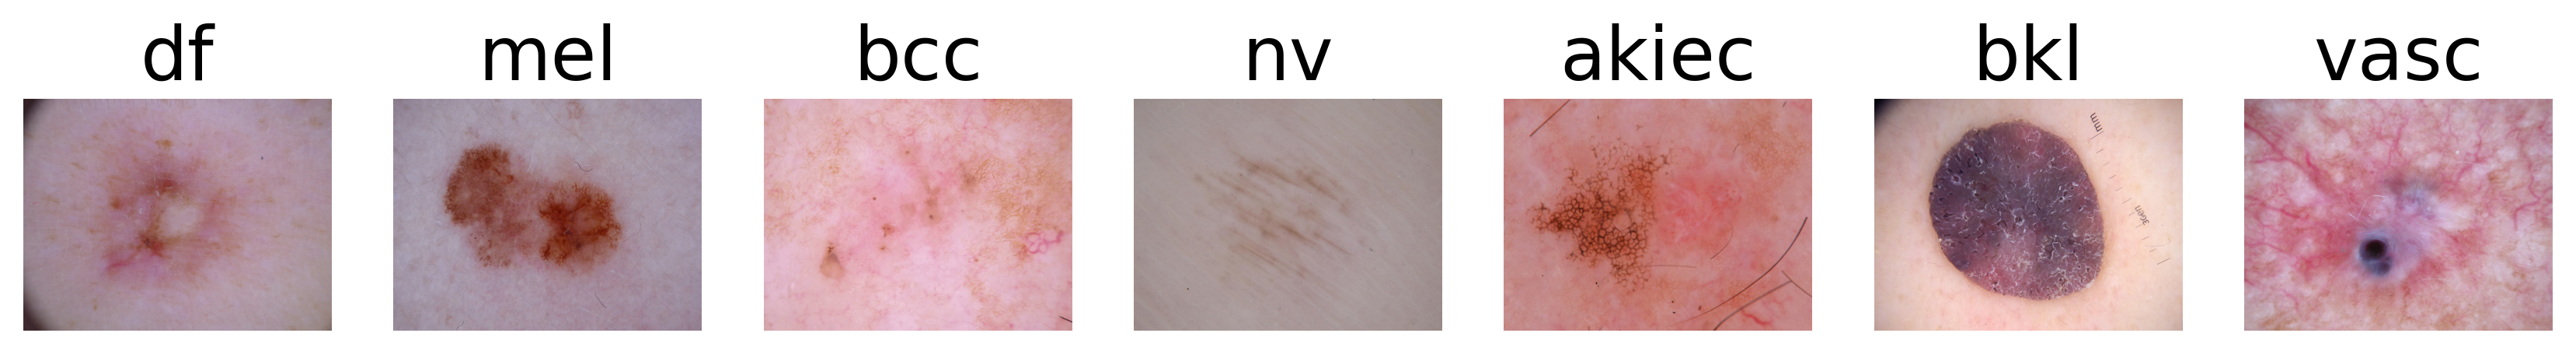

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

SEED = 1023
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

image_folder_path = "/content/HAM10000"

classes = os.listdir(image_folder_path)

fig, axes = plt.subplots(1, len(classes), figsize=(14,2))

for i, cls in enumerate(classes):
    class_folder_path = os.path.join(image_folder_path, cls)
    image_files = os.listdir(class_folder_path)

    image_file = np.random.choice(image_files)
    image_path = os.path.join(class_folder_path, image_file)

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

dst_fig = "/content/figs"
if not os.path.exists(dst_fig):
    os.makedirs(dst_fig)
plt.savefig("/content/figs/examples.png", dpi=300)
plt.show()

In [ ]:
from torch.utils.data import random_split
from torchvision import datasets, transforms

SEED = 1023
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

checkpoint_folder = "/content/HAM10000/.ipynb_checkpoints"

if os.path.exists(checkpoint_folder):
    shutil.rmtree(checkpoint_folder)

dataset = datasets.ImageFolder("/content/HAM10000")

In [ ]:
from collections import Counter

labels = dataset.targets

label_counts = Counter(labels)

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 327
Label: 1, Count: 514
Label: 2, Count: 1099
Label: 3, Count: 115
Label: 4, Count: 1113
Label: 5, Count: 6705
Label: 6, Count: 142


In [ ]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),

    'val_test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
val_dataset = MyDataset(val_dataset, transform=data_transforms['val_test'])
test_dataset = MyDataset(test_dataset, transform=data_transforms['val_test'])

In [ ]:
all_dataset = MyDataset(dataset, transform=data_transforms['val_test'])

In [ ]:
!pip install dill
import dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
with open('./train_dataset_save.pkl','wb') as f:
    dill.dump(train_dataset, f)

In [ ]:
with open('./val_dataset_save.pkl','wb') as f:
    dill.dump(val_dataset, f)

In [ ]:
with open('./test_dataset_save.pkl','wb') as f:
    dill.dump(test_dataset, f)

In [ ]:
!cp train_dataset_save.pkl /content/drive/MyDrive/Dataset_np

In [ ]:
!cp val_dataset_save.pkl /content/drive/MyDrive/Dataset_np

In [ ]:
!cp test_dataset_save.pkl /content/drive/MyDrive/Dataset_np

In [ ]:
print(dataset.class_to_idx)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
class_to_idx = dataset.class_to_idx

idx_to_class = {v: k for k, v in class_to_idx.items()}

total_labels = [label for _, label in dataset]
total_counts = np.bincount(total_labels)

train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]

train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)
test_counts = np.bincount(test_labels)

class_names = [idx_to_class[i] for i in range(len(total_counts))]

             Total     Train       Val      Test
Category                                        
akiec     0.032651  0.033450  0.027459  0.035447
bcc       0.051323  0.050258  0.049925  0.055916
bkl       0.109735  0.109170  0.118323  0.102846
df        0.011483  0.010817  0.010484  0.014478
mel       0.111133  0.108837  0.115826  0.113330
nv        0.669496  0.674488  0.663005  0.661008
vasc      0.014179  0.012981  0.014978  0.016975


<Axes: xlabel='Category'>

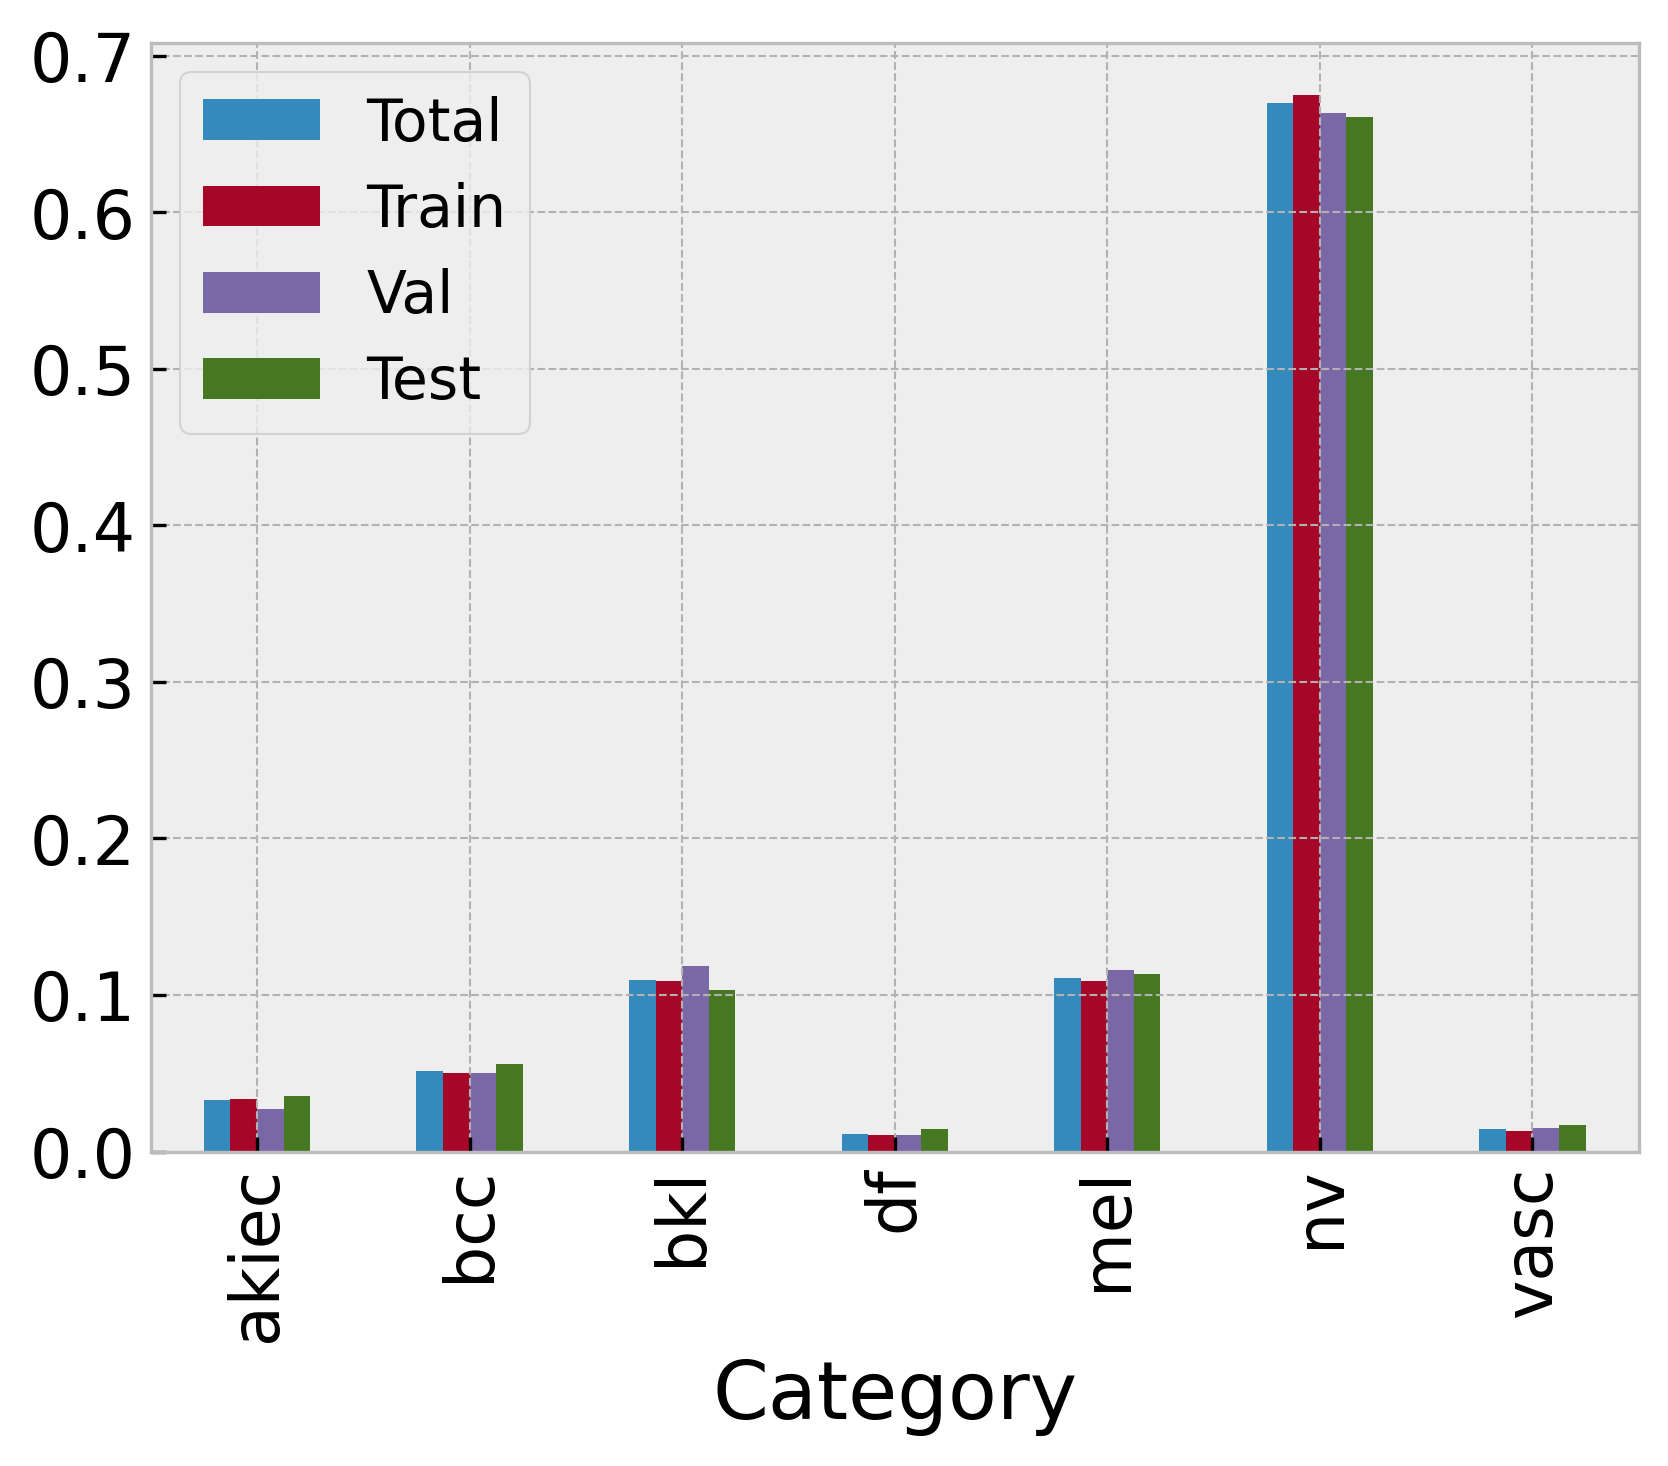

In [ ]:
cnt_df = pd.DataFrame({
    'Category': class_names,
    'Total': total_counts,
    'Train': train_counts,
    'Val': val_counts,
    'Test': test_counts
})

cnt_df = cnt_df.set_index('Category')
cnt_df = cnt_df / cnt_df.sum()

print(cnt_df)

cnt_df.plot(kind='bar')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [ ]:
sample_path, label_index = dataset[1145]
print("Sample Path:", sample_path)
print("Label Index:", label_index)
label = dataset.classes[label_index]
print("Label:", label)

Sample Path: <PIL.Image.Image image mode=RGB size=600x450 at 0x7F632BD2D5D0>
Label Index: 2
Label: bkl


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
all_loader = torch.utils.data.DataLoader(all_dataset,batch_size=batch_size, shuffle=True)

In [ ]:
size1 = len(train_loader)
size2 = len(val_loader)
size3 = len(test_loader)
size4 = len(all_loader)
print(size1,size2,size3,size4)

188 63 63 313


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dpcw')
# from vgg import VGG_D

In [ ]:
device = "cuda"

In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # randomly sample a probability from a uniform distribution
    else:
        lam = 1
    batch_size = x.shape[0]
    index = np.random.choice(batch_size, batch_size, replace=False) # randomly shuffle the entire index
    mixed_x = lam * x + (1 - lam) * x[index] # mix the image
    y_b = y[index] # keep both labels on y and y_b for criterion
    return mixed_x, y, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b) # combine and calculate mixed losses

# VGG16_bn

In [ ]:
# class VGG_D(nn.Module):
#     def __init__(self, num_classes=7, hidden_dims=[64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]):
#         super(VGG_D, self).__init__()
#         convs = []
#         input_dim = 3
#         for i, hidden_dim in enumerate(hidden_dims):
#             convs.append(nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1))
#             convs.append(nn.BatchNorm2d(hidden_dim))
#             convs.append(nn.ReLU())
#             input_dim = hidden_dim
#             if i in [1, 3, 6, 9, 12]:
#                 convs.append(nn.MaxPool2d(kernel_size=2, stride=2))
#         self.convs = nn.Sequential(*convs)
#         num_features_after_cnn = np.prod(list(self.convs(torch.randn(1, 3, 224, 224)).shape))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(num_features_after_cnn, 4096),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Linear(4096, num_classes))

#     @torch.no_grad()
#     def get_reprs(self, x):
#         out = self.convs(x)
#         out = out.reshape(out.shape[0], -1)
#         return out
#     def forward(self, x):
#         out = self.convs(x)
#         out = out.reshape(out.shape[0], -1)
#         out = self.fc(out)
#         return out

In [ ]:
!pip install timm

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

In [ ]:
model = timm.create_model(
    'vgg16_bn.tv_in1k',
    pretrained=False,
    num_classes=7,
)

In [ ]:
batch_size = 32

In [ ]:
from tqdm import tqdm
def train_and_validate(model, train_loader, val_loader, epochs, optimizer, loss_fn, device):
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        pbar = tqdm(train_loader, ncols=80)
        for data, labels in pbar:
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds

        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} : Training loss: {epoch_loss:.5f}, Training accuracy: {epoch_acc:.5f}")

        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        pbar = tqdm(val_loader, ncols=80)

        with torch.no_grad():
            for data, labels in pbar:
                data = data.to(device)
                labels = labels.to(device)

                outputs = model(data)
                loss = loss_fn(outputs, labels)

                running_loss += loss.item() * data.size(0)
                _, preds = torch.max(outputs, 1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = correct_preds / total_preds

            val_loss_list.append(epoch_loss)
            val_acc_list.append(epoch_acc)

            print(f"Epoch {epoch+1}/{epochs} : Validation loss: {epoch_loss:.5f}, Validation accuracy: {epoch_acc:.5f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
def test(model, test_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds

    return test_loss, test_acc

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs = 20
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = model.to(device)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
train_loss, train_acc, val_loss, val_acc = train_and_validate(model, train_loader, val_loader, epochs, optimizer, loss_fn, device)

100%|█████████████████████████████████████████| 188/188 [02:21<00:00,  1.33it/s]


Epoch 1/20 : Training loss: 1.97813, Training accuracy: 0.65602


100%|███████████████████████████████████████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch 1/20 : Validation loss: 0.98195, Validation accuracy: 0.66301


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.46it/s]


Epoch 2/20 : Training loss: 1.01292, Training accuracy: 0.67482


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch 2/20 : Validation loss: 0.95768, Validation accuracy: 0.66201


100%|█████████████████████████████████████████| 188/188 [02:07<00:00,  1.47it/s]


Epoch 3/20 : Training loss: 1.00876, Training accuracy: 0.67316


100%|███████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch 3/20 : Validation loss: 0.96730, Validation accuracy: 0.66301


100%|█████████████████████████████████████████| 188/188 [02:11<00:00,  1.43it/s]


Epoch 4/20 : Training loss: 0.99220, Training accuracy: 0.67499


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch 4/20 : Validation loss: 1.02582, Validation accuracy: 0.66301


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.46it/s]


Epoch 5/20 : Training loss: 0.97684, Training accuracy: 0.67299


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch 5/20 : Validation loss: 0.91848, Validation accuracy: 0.66301


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.46it/s]


Epoch 6/20 : Training loss: 0.95254, Training accuracy: 0.67698


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch 6/20 : Validation loss: 0.93554, Validation accuracy: 0.66301


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.46it/s]


Epoch 7/20 : Training loss: 0.95066, Training accuracy: 0.67549


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch 7/20 : Validation loss: 0.96492, Validation accuracy: 0.67449


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.47it/s]


Epoch 8/20 : Training loss: 0.94421, Training accuracy: 0.67715


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch 8/20 : Validation loss: 0.89682, Validation accuracy: 0.66850


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 9/20 : Training loss: 0.92295, Training accuracy: 0.67798


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch 9/20 : Validation loss: 0.90018, Validation accuracy: 0.67099


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 10/20 : Training loss: 0.92891, Training accuracy: 0.67316


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch 10/20 : Validation loss: 0.93554, Validation accuracy: 0.68547


100%|█████████████████████████████████████████| 188/188 [02:12<00:00,  1.42it/s]


Epoch 11/20 : Training loss: 0.90139, Training accuracy: 0.68381


100%|███████████████████████████████████████████| 63/63 [00:33<00:00,  1.87it/s]


Epoch 11/20 : Validation loss: 0.84458, Validation accuracy: 0.68997


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 12/20 : Training loss: 0.89790, Training accuracy: 0.68697


100%|███████████████████████████████████████████| 63/63 [00:35<00:00,  1.80it/s]


Epoch 12/20 : Validation loss: 0.82511, Validation accuracy: 0.69296


100%|█████████████████████████████████████████| 188/188 [02:12<00:00,  1.42it/s]


Epoch 13/20 : Training loss: 0.88002, Training accuracy: 0.68680


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Epoch 13/20 : Validation loss: 0.83709, Validation accuracy: 0.68248


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 14/20 : Training loss: 0.86169, Training accuracy: 0.69462


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch 14/20 : Validation loss: 0.86244, Validation accuracy: 0.69695


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 15/20 : Training loss: 0.85995, Training accuracy: 0.68863


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch 15/20 : Validation loss: 0.81981, Validation accuracy: 0.69146


100%|█████████████████████████████████████████| 188/188 [02:10<00:00,  1.44it/s]


Epoch 16/20 : Training loss: 0.85849, Training accuracy: 0.69246


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Epoch 16/20 : Validation loss: 0.80821, Validation accuracy: 0.70295


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.46it/s]


Epoch 17/20 : Training loss: 0.84925, Training accuracy: 0.69579


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch 17/20 : Validation loss: 0.78407, Validation accuracy: 0.71143


100%|█████████████████████████████████████████| 188/188 [02:09<00:00,  1.45it/s]


Epoch 18/20 : Training loss: 0.85352, Training accuracy: 0.69296


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch 18/20 : Validation loss: 0.82490, Validation accuracy: 0.69695


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.47it/s]


Epoch 19/20 : Training loss: 0.84211, Training accuracy: 0.69496


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch 19/20 : Validation loss: 0.79501, Validation accuracy: 0.70944


100%|█████████████████████████████████████████| 188/188 [02:08<00:00,  1.46it/s]


Epoch 20/20 : Training loss: 0.83757, Training accuracy: 0.69512


100%|███████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]

Epoch 20/20 : Validation loss: 0.77598, Validation accuracy: 0.70794


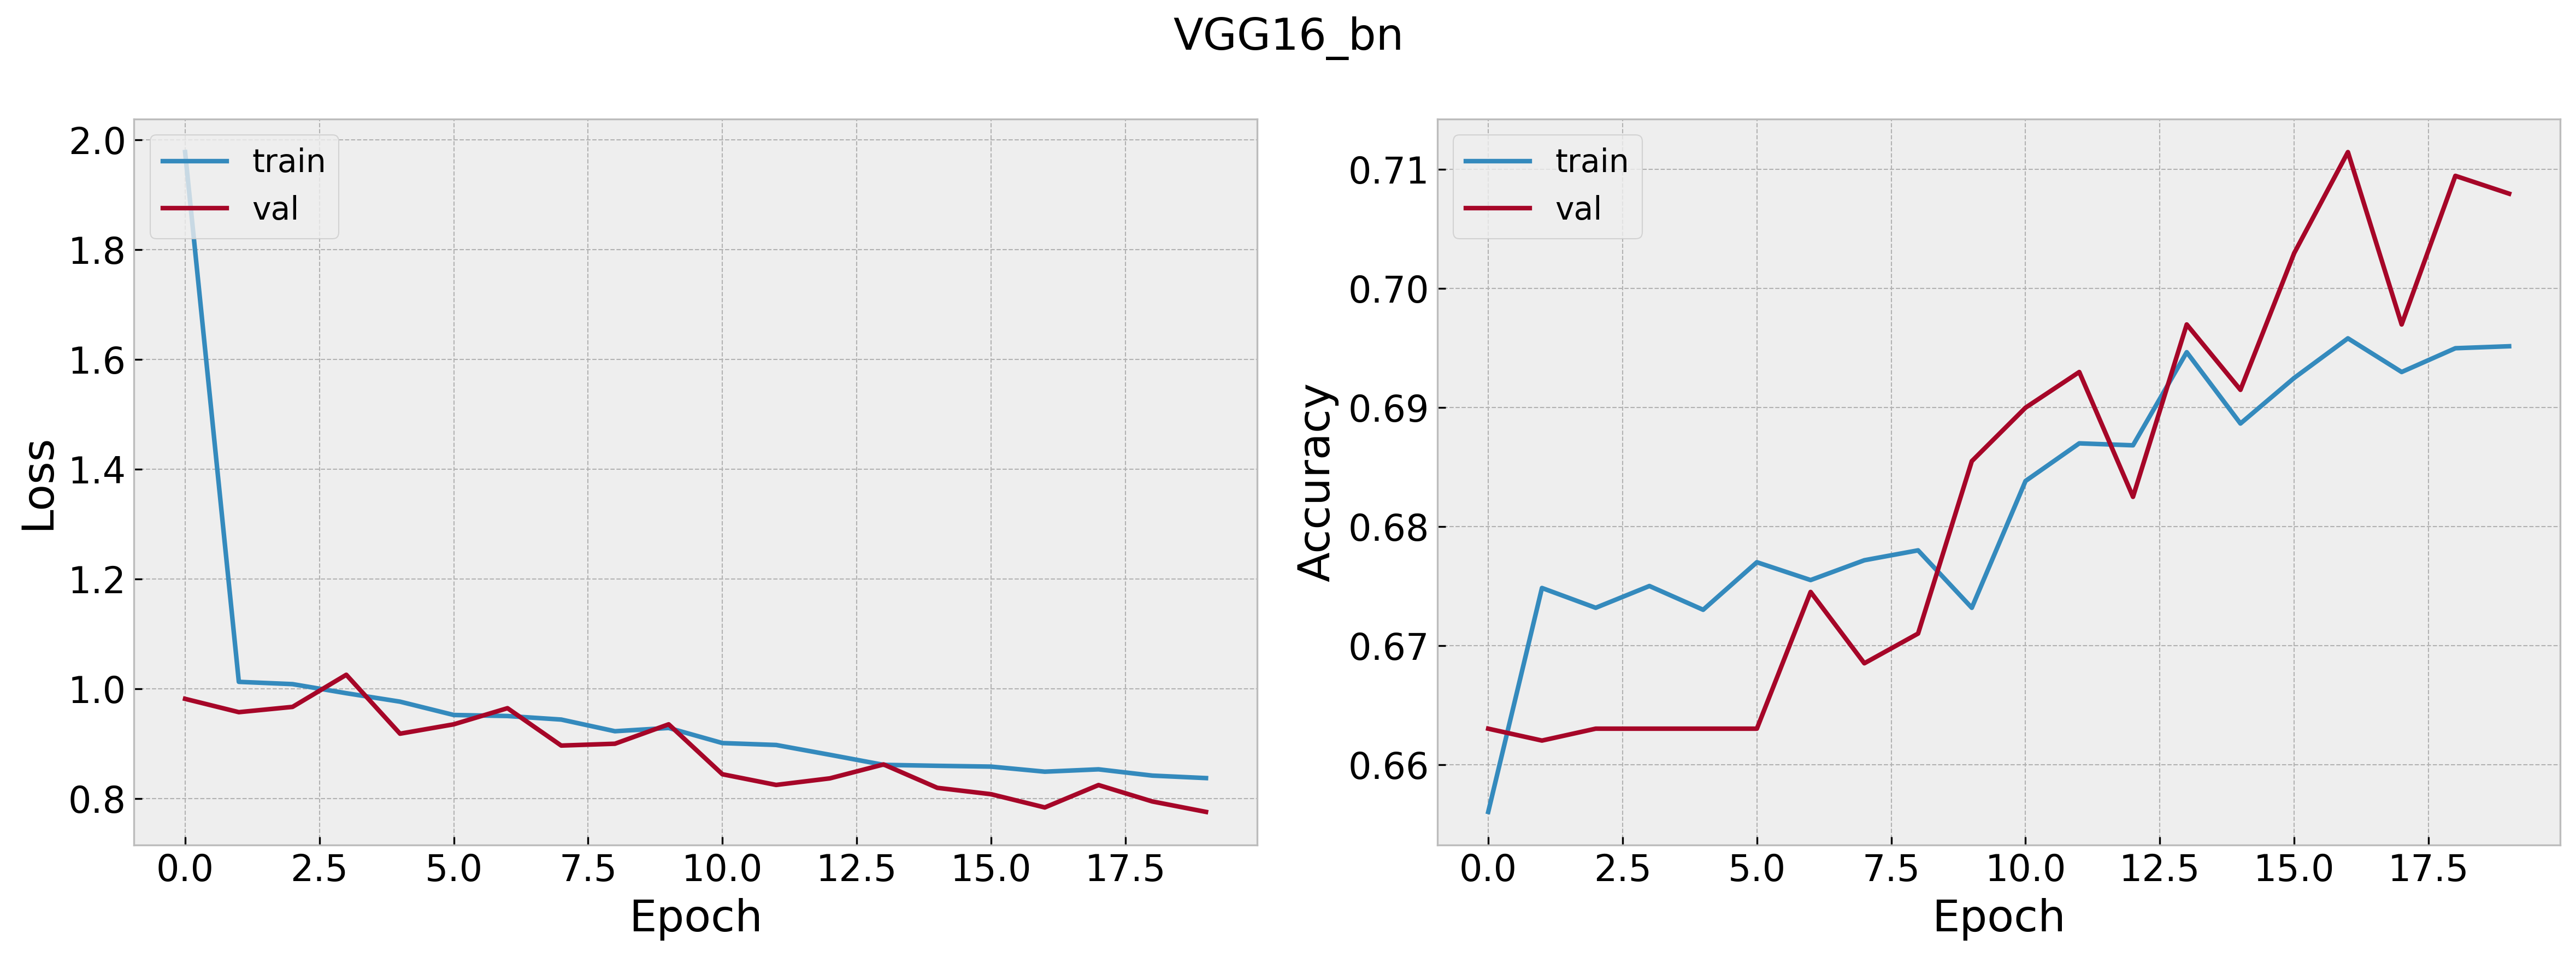

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(train_loss, label='train')
_ = plt.plot(val_loss, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)

_ = plt.plot(train_acc, label='train')
_ = plt.plot(val_acc, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("VGG16_bn")
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = test(model, test_loader, loss_fn, device)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.79116, Test accuracy: 0.69695


In [ ]:
with open('datavgg16bn.txt', 'w') as f:
    f.write("train_loss: {}\n".format(train_loss))
    f.write("train_acc: {}\n".format(train_acc))
    f.write("val_loss: {}\n".format(val_loss))
    f.write("val_acc: {}\n".format(val_acc))

# loaded_train_loss, loaded_train_acc, loaded_val_loss, loaded_val_acc = [], [], [], []
# with open('train_val_data.txt', 'r') as f:
#     lines = f.readlines()
#     loaded_train_loss = eval(lines[0].split(": ")[1])
#     loaded_train_acc = eval(lines[1].split(": ")[1])
#     loaded_val_loss = eval(lines[2].split(": ")[1])
#     loaded_val_acc = eval(lines[3].split(": ")[1])

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# ResNet18

In [ ]:
model_3 = timm.create_model(
    'resnet18.a1_in1k',
    pretrained=False,
    num_classes=7,
)

In [ ]:
optimizer = optim.Adam(model_3.parameters(), lr=1e-4)
epochs = 20
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model_3 = model_3.to(device)

In [ ]:
train_loss_3, train_acc_3, val_loss_3, val_acc_3 = train_and_validate(model_3, train_loader, val_loader, epochs, optimizer, loss_fn, device)

100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 1/20 : Training loss: 1.07418, Training accuracy: 0.66384


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 1/20 : Validation loss: 0.91476, Validation accuracy: 0.68098


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 2/20 : Training loss: 0.91254, Training accuracy: 0.68647


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 2/20 : Validation loss: 0.87156, Validation accuracy: 0.69446


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 3/20 : Training loss: 0.87984, Training accuracy: 0.68597


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 3/20 : Validation loss: 0.83895, Validation accuracy: 0.70095


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 4/20 : Training loss: 0.86293, Training accuracy: 0.68863


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.26it/s]


Epoch 4/20 : Validation loss: 0.91184, Validation accuracy: 0.67299


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.19it/s]


Epoch 5/20 : Training loss: 0.85022, Training accuracy: 0.69196


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 5/20 : Validation loss: 0.80135, Validation accuracy: 0.70594


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 6/20 : Training loss: 0.83572, Training accuracy: 0.69263


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 6/20 : Validation loss: 0.78596, Validation accuracy: 0.70994


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 7/20 : Training loss: 0.81899, Training accuracy: 0.69945


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 7/20 : Validation loss: 0.77938, Validation accuracy: 0.71792


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 8/20 : Training loss: 0.80963, Training accuracy: 0.70295


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 8/20 : Validation loss: 0.78646, Validation accuracy: 0.71892


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 9/20 : Training loss: 0.81373, Training accuracy: 0.69829


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 9/20 : Validation loss: 0.75860, Validation accuracy: 0.70844


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.16it/s]


Epoch 10/20 : Training loss: 0.80395, Training accuracy: 0.70095


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 10/20 : Validation loss: 0.75942, Validation accuracy: 0.71742


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 11/20 : Training loss: 0.80247, Training accuracy: 0.70361


100%|███████████████████████████████████████████| 63/63 [00:28<00:00,  2.24it/s]


Epoch 11/20 : Validation loss: 0.80014, Validation accuracy: 0.72591


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 12/20 : Training loss: 0.79375, Training accuracy: 0.70411


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.26it/s]


Epoch 12/20 : Validation loss: 0.73745, Validation accuracy: 0.73640


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 13/20 : Training loss: 0.78116, Training accuracy: 0.71360


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 13/20 : Validation loss: 0.72603, Validation accuracy: 0.73590


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 14/20 : Training loss: 0.77919, Training accuracy: 0.70844


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 14/20 : Validation loss: 0.71768, Validation accuracy: 0.73939


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 15/20 : Training loss: 0.77754, Training accuracy: 0.70877


100%|███████████████████████████████████████████| 63/63 [00:28<00:00,  2.25it/s]


Epoch 15/20 : Validation loss: 0.72036, Validation accuracy: 0.72491


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 16/20 : Training loss: 0.76628, Training accuracy: 0.71426


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 16/20 : Validation loss: 0.70540, Validation accuracy: 0.73640


100%|█████████████████████████████████████████| 188/188 [01:27<00:00,  2.16it/s]


Epoch 17/20 : Training loss: 0.75973, Training accuracy: 0.72341


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 17/20 : Validation loss: 0.70293, Validation accuracy: 0.74039


100%|█████████████████████████████████████████| 188/188 [01:27<00:00,  2.16it/s]


Epoch 18/20 : Training loss: 0.75702, Training accuracy: 0.72092


100%|███████████████████████████████████████████| 63/63 [00:28<00:00,  2.25it/s]


Epoch 18/20 : Validation loss: 0.71439, Validation accuracy: 0.74588


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 19/20 : Training loss: 0.75344, Training accuracy: 0.72708


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 19/20 : Validation loss: 0.68822, Validation accuracy: 0.74438


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 20/20 : Training loss: 0.74764, Training accuracy: 0.72458


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]

Epoch 20/20 : Validation loss: 0.68608, Validation accuracy: 0.74338


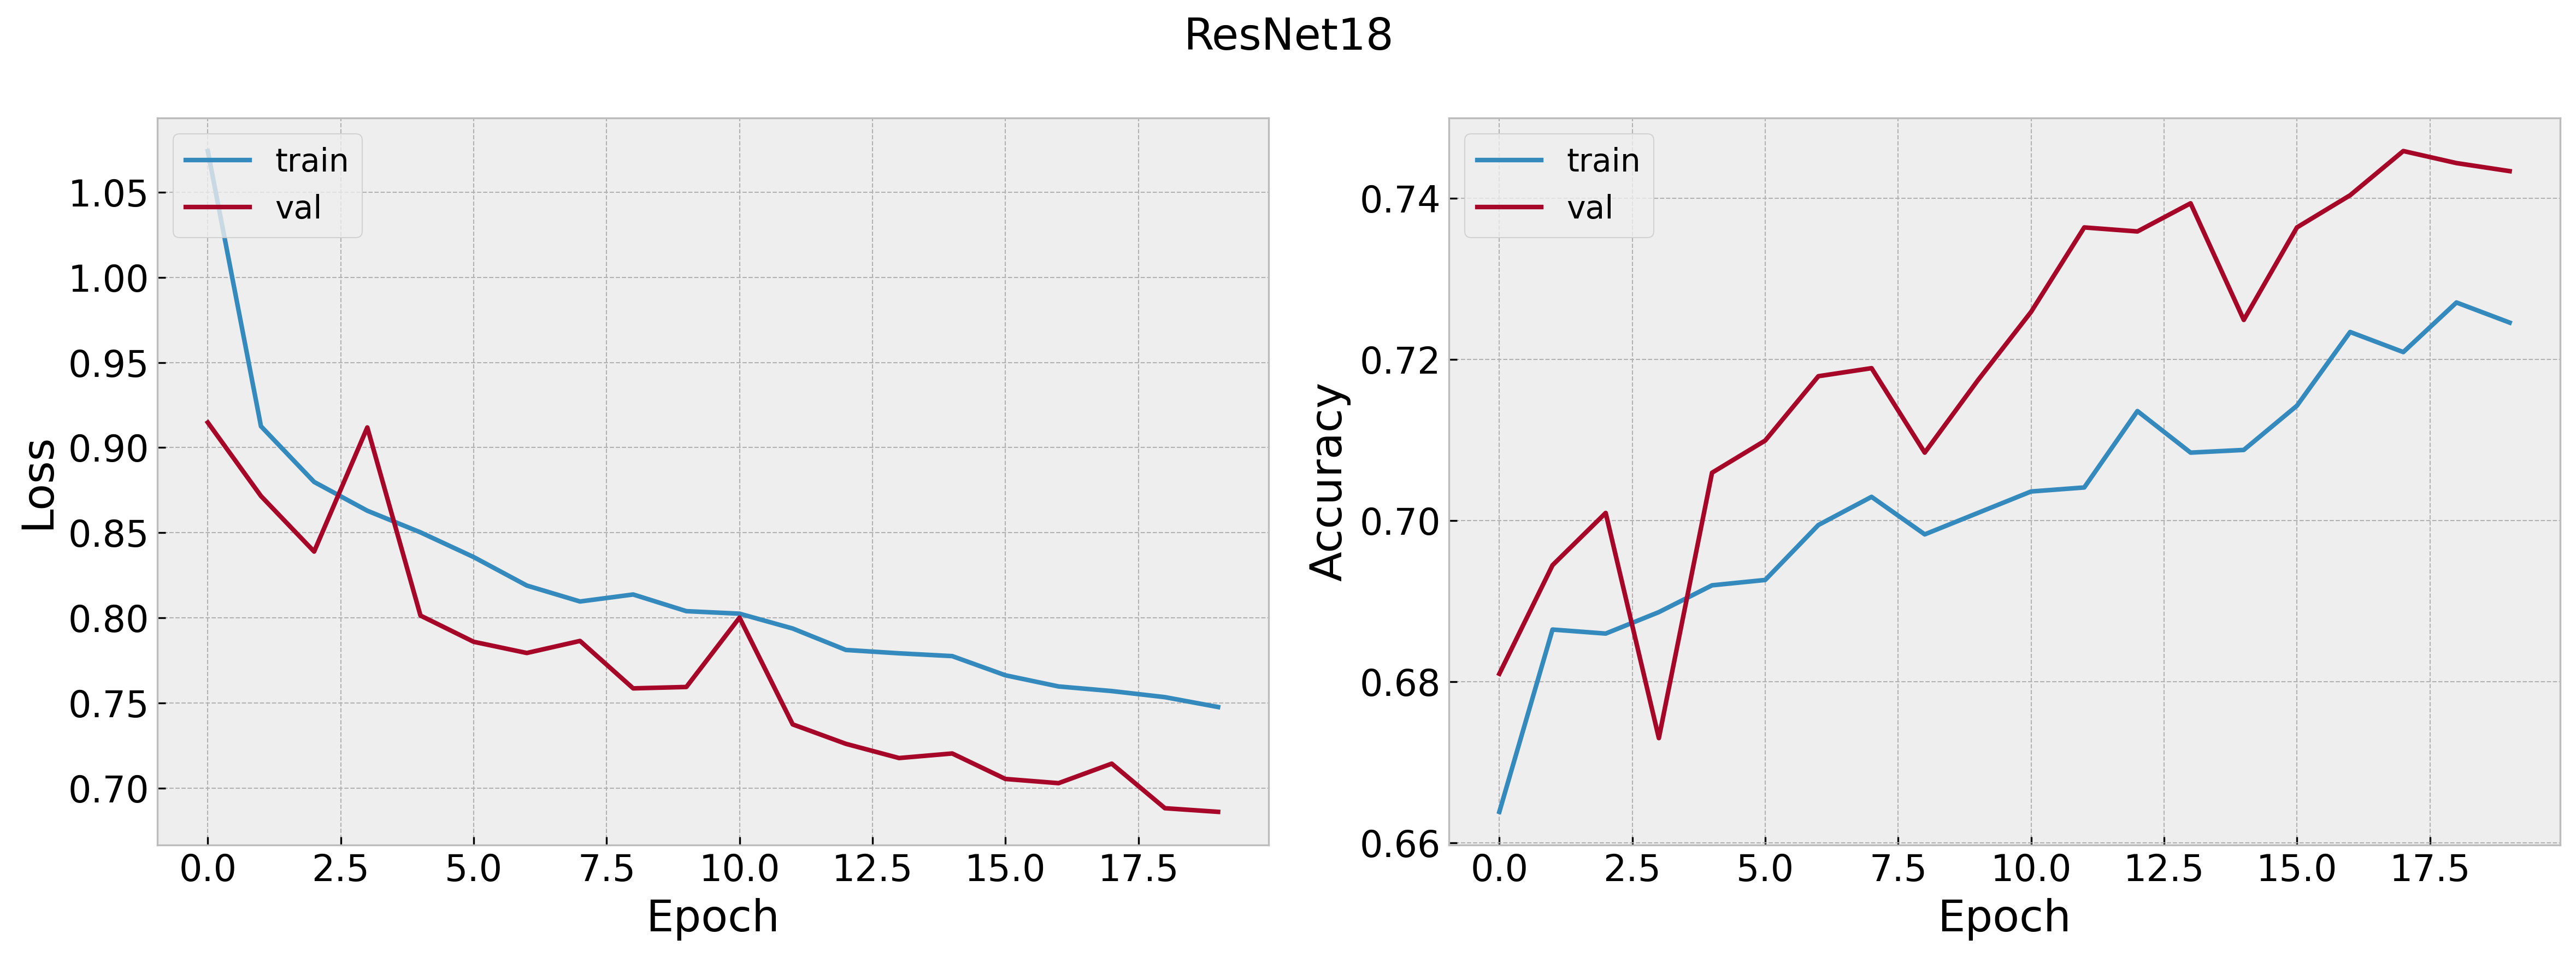

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(train_loss_3, label='train')
_ = plt.plot(val_loss_3, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)

_ = plt.plot(train_acc_3, label='train')
_ = plt.plot(val_acc_3, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("ResNet18")
plt.tight_layout()
plt.show()

In [ ]:
test_loss_3, test_acc_3 = test(model_3, test_loader, loss_fn, device)
print(f"Test loss: {test_loss_3:.5f}, Test accuracy: {test_acc_3:.5f}")

Test loss: 0.71293, Test accuracy: 0.73240


In [ ]:
with open('dataresnet18.txt', 'w') as f:
    f.write("train_loss: {}\n".format(train_loss_3))
    f.write("train_acc: {}\n".format(train_acc_3))
    f.write("val_loss: {}\n".format(val_loss_3))
    f.write("val_acc: {}\n".format(val_acc_3))

410

410

407

406

In [ ]:
torch.save(model_3.state_dict(), 'model_3.pth')

# ResNet18(Fine-tuning on Pre-trained Model)

In [ ]:
model_1 = timm.create_model(
    'resnet18.a1_in1k',
    pretrained=True,
    num_classes=7,
)

In [ ]:
optimizer = optim.Adam(model_1.parameters(), lr=1e-4)
epochs = 20
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model_1 = model_1.to(device)

In [ ]:
print(model_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
train_loss_1, train_acc_1, val_loss_1, val_acc_1 = train_and_validate(model_1, train_loader, val_loader, epochs, optimizer, loss_fn, device)

100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.98it/s]


Epoch 1/20 : Training loss: 1.16733, Training accuracy: 0.65152


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.12it/s]


Epoch 1/20 : Validation loss: 0.95692, Validation accuracy: 0.68697


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.99it/s]


Epoch 2/20 : Training loss: 0.84424, Training accuracy: 0.69812


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.08it/s]


Epoch 2/20 : Validation loss: 0.77276, Validation accuracy: 0.73540


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  2.00it/s]


Epoch 3/20 : Training loss: 0.75871, Training accuracy: 0.72092


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.11it/s]


Epoch 3/20 : Validation loss: 0.70226, Validation accuracy: 0.75137


100%|█████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]


Epoch 4/20 : Training loss: 0.70617, Training accuracy: 0.74122


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.09it/s]


Epoch 4/20 : Validation loss: 0.64579, Validation accuracy: 0.77084


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 5/20 : Training loss: 0.66861, Training accuracy: 0.76452


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.12it/s]


Epoch 5/20 : Validation loss: 0.61976, Validation accuracy: 0.77883


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.98it/s]


Epoch 6/20 : Training loss: 0.63305, Training accuracy: 0.77168


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.10it/s]


Epoch 6/20 : Validation loss: 0.58213, Validation accuracy: 0.79031


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.98it/s]


Epoch 7/20 : Training loss: 0.60634, Training accuracy: 0.78233


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.07it/s]


Epoch 7/20 : Validation loss: 0.55956, Validation accuracy: 0.79331


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.96it/s]


Epoch 8/20 : Training loss: 0.58126, Training accuracy: 0.79481


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.10it/s]


Epoch 8/20 : Validation loss: 0.53752, Validation accuracy: 0.80679


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.98it/s]


Epoch 9/20 : Training loss: 0.56518, Training accuracy: 0.79814


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.10it/s]


Epoch 9/20 : Validation loss: 0.51360, Validation accuracy: 0.81028


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.99it/s]


Epoch 10/20 : Training loss: 0.54218, Training accuracy: 0.80313


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.12it/s]


Epoch 10/20 : Validation loss: 0.51375, Validation accuracy: 0.81028


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.98it/s]


Epoch 11/20 : Training loss: 0.51767, Training accuracy: 0.81162


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.12it/s]


Epoch 11/20 : Validation loss: 0.50761, Validation accuracy: 0.81628


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.98it/s]


Epoch 12/20 : Training loss: 0.50755, Training accuracy: 0.81894


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch 12/20 : Validation loss: 0.50825, Validation accuracy: 0.82277


100%|█████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]


Epoch 13/20 : Training loss: 0.50616, Training accuracy: 0.81428


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.10it/s]


Epoch 13/20 : Validation loss: 0.48747, Validation accuracy: 0.82177


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 14/20 : Training loss: 0.48830, Training accuracy: 0.82410


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.08it/s]


Epoch 14/20 : Validation loss: 0.46927, Validation accuracy: 0.82776


100%|█████████████████████████████████████████| 188/188 [01:34<00:00,  1.99it/s]


Epoch 15/20 : Training loss: 0.47240, Training accuracy: 0.83075


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.11it/s]


Epoch 15/20 : Validation loss: 0.47768, Validation accuracy: 0.82926


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 16/20 : Training loss: 0.46469, Training accuracy: 0.83109


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.09it/s]


Epoch 16/20 : Validation loss: 0.45830, Validation accuracy: 0.82676


100%|█████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]


Epoch 17/20 : Training loss: 0.44610, Training accuracy: 0.83907


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.09it/s]


Epoch 17/20 : Validation loss: 0.46853, Validation accuracy: 0.82926


100%|█████████████████████████████████████████| 188/188 [01:36<00:00,  1.95it/s]


Epoch 18/20 : Training loss: 0.43452, Training accuracy: 0.84507


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.06it/s]


Epoch 18/20 : Validation loss: 0.46146, Validation accuracy: 0.83025


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 19/20 : Training loss: 0.42162, Training accuracy: 0.84806


100%|███████████████████████████████████████████| 63/63 [00:30<00:00,  2.06it/s]


Epoch 19/20 : Validation loss: 0.48379, Validation accuracy: 0.82926


100%|█████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 20/20 : Training loss: 0.42455, Training accuracy: 0.84690


100%|███████████████████████████████████████████| 63/63 [00:29<00:00,  2.11it/s]

Epoch 20/20 : Validation loss: 0.48798, Validation accuracy: 0.82726


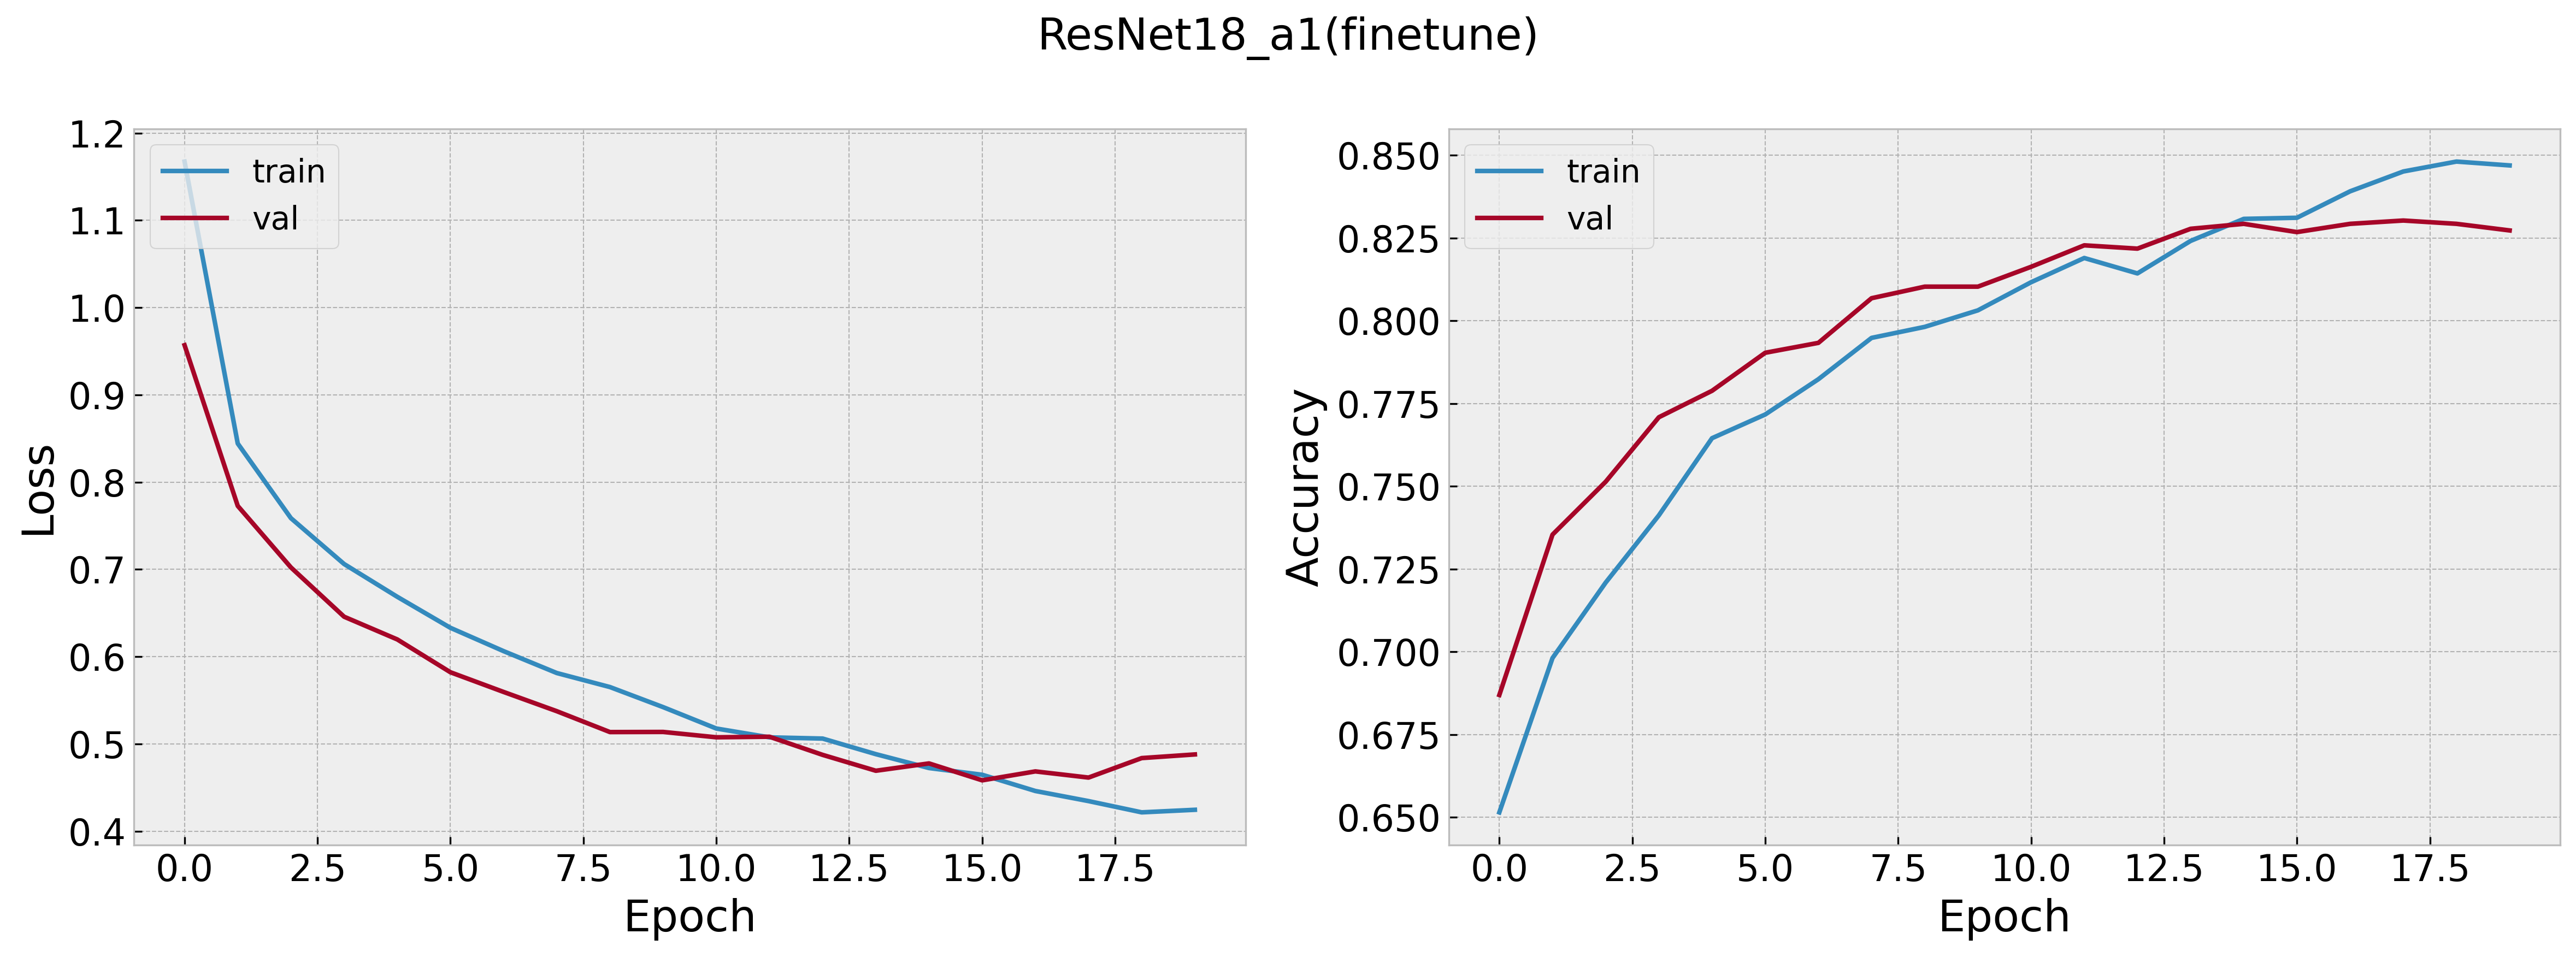

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(train_loss_1, label='train')
_ = plt.plot(val_loss_1, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)

_ = plt.plot(train_acc_1, label='train')
_ = plt.plot(val_acc_1, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("ResNet18_a1(finetune)")
plt.tight_layout()
plt.show()

In [ ]:
test_loss_1, test_acc_1 = test(model_1, test_loader, loss_fn, device)
print(f"Test loss: {test_loss_1:.5f}, Test accuracy: {test_acc_1:.5f}")

Test loss: 0.48664, Test accuracy: 0.82676


In [ ]:
with open('datareset18a1.txt', 'w') as f:
    f.write("train_loss: {}\n".format(train_loss_1))
    f.write("train_acc: {}\n".format(train_acc_1))
    f.write("val_loss: {}\n".format(val_loss_1))
    f.write("val_acc: {}\n".format(val_acc_1))

417

407

413

410

In [ ]:
torch.save(model_1.state_dict(), 'model_1.pth')

# BYOL + ResNet18

In [ ]:
model_2 = timm.create_model(
    'resnet18.a1_in1k',
    pretrained=False,
    num_classes=7,
)

In [ ]:
print(model_2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
!pip install byol-pytorch

In [ ]:
from byol_pytorch import BYOL
import torch
from torchvision import models

In [ ]:
learner = BYOL(
    model_2,
    image_size = 224,
    hidden_layer = 'global_pool'
)

optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)

In [ ]:
learner = learner.to(device)

In [ ]:
from tqdm import tqdm
# stage 1: unsupervised learning (pretrain)
for epoch in range(100):
    pbar = tqdm(all_loader, desc=f"Epoch {epoch+1}/100")
    for images, _ in pbar: # Ignore labels
        images = images.to(device)
        loss = learner(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()
        pbar.set_postfix({"Loss": loss.item()})

Epoch 100/100: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s, Loss=0.225]


In [ ]:
# stage 2: supervised learning (finetune)

In [ ]:
torch.save(model_2.state_dict(), 'model_2.pth')

In [ ]:
optimizer = optim.Adam(model_2.parameters(), lr=1e-4)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
model_2 = model_2.to(device)
train_loss_2, train_acc_2, val_loss_2, val_acc_2 = train_and_validate(model_2, train_loader, val_loader, epochs, optimizer, loss_fn, device)

100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 1/20 : Training loss: 1.09008, Training accuracy: 0.68131


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 1/20 : Validation loss: 0.83353, Validation accuracy: 0.69995


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 2/20 : Training loss: 0.83667, Training accuracy: 0.70344


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 2/20 : Validation loss: 0.75271, Validation accuracy: 0.72092


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 3/20 : Training loss: 0.79492, Training accuracy: 0.71443


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 3/20 : Validation loss: 0.72682, Validation accuracy: 0.74139


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 4/20 : Training loss: 0.76466, Training accuracy: 0.72491


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.26it/s]


Epoch 4/20 : Validation loss: 0.71850, Validation accuracy: 0.73839


100%|█████████████████████████████████████████| 188/188 [01:25<00:00,  2.19it/s]


Epoch 5/20 : Training loss: 0.75175, Training accuracy: 0.72741


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 5/20 : Validation loss: 0.69145, Validation accuracy: 0.74538


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 6/20 : Training loss: 0.73856, Training accuracy: 0.73906


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 6/20 : Validation loss: 0.69311, Validation accuracy: 0.75187


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 7/20 : Training loss: 0.71686, Training accuracy: 0.74189


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 7/20 : Validation loss: 0.67741, Validation accuracy: 0.75387


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.19it/s]


Epoch 8/20 : Training loss: 0.70565, Training accuracy: 0.74355


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 8/20 : Validation loss: 0.65957, Validation accuracy: 0.75936


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 9/20 : Training loss: 0.70190, Training accuracy: 0.73906


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 9/20 : Validation loss: 0.64324, Validation accuracy: 0.75736


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 10/20 : Training loss: 0.68134, Training accuracy: 0.75354


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.25it/s]


Epoch 10/20 : Validation loss: 0.63648, Validation accuracy: 0.76485


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 11/20 : Training loss: 0.67365, Training accuracy: 0.75553


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 11/20 : Validation loss: 0.63973, Validation accuracy: 0.76236


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 12/20 : Training loss: 0.66393, Training accuracy: 0.75337


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 12/20 : Validation loss: 0.63721, Validation accuracy: 0.77334


100%|█████████████████████████████████████████| 188/188 [01:25<00:00,  2.19it/s]


Epoch 13/20 : Training loss: 0.65557, Training accuracy: 0.75986


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.25it/s]


Epoch 13/20 : Validation loss: 0.62289, Validation accuracy: 0.77134


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 14/20 : Training loss: 0.64476, Training accuracy: 0.76435


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 14/20 : Validation loss: 0.61534, Validation accuracy: 0.77983


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 15/20 : Training loss: 0.64359, Training accuracy: 0.76519


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.26it/s]


Epoch 15/20 : Validation loss: 0.62514, Validation accuracy: 0.77434


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 16/20 : Training loss: 0.64138, Training accuracy: 0.76918


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 16/20 : Validation loss: 0.64650, Validation accuracy: 0.76985


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 17/20 : Training loss: 0.62714, Training accuracy: 0.76801


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 17/20 : Validation loss: 0.64623, Validation accuracy: 0.77434


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 18/20 : Training loss: 0.61240, Training accuracy: 0.77484


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 18/20 : Validation loss: 0.62266, Validation accuracy: 0.78782


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 19/20 : Training loss: 0.61230, Training accuracy: 0.77600


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]


Epoch 19/20 : Validation loss: 0.59911, Validation accuracy: 0.78532


100%|█████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 20/20 : Training loss: 0.61064, Training accuracy: 0.77467


100%|███████████████████████████████████████████| 63/63 [00:27<00:00,  2.25it/s]

Epoch 20/20 : Validation loss: 0.59838, Validation accuracy: 0.79231


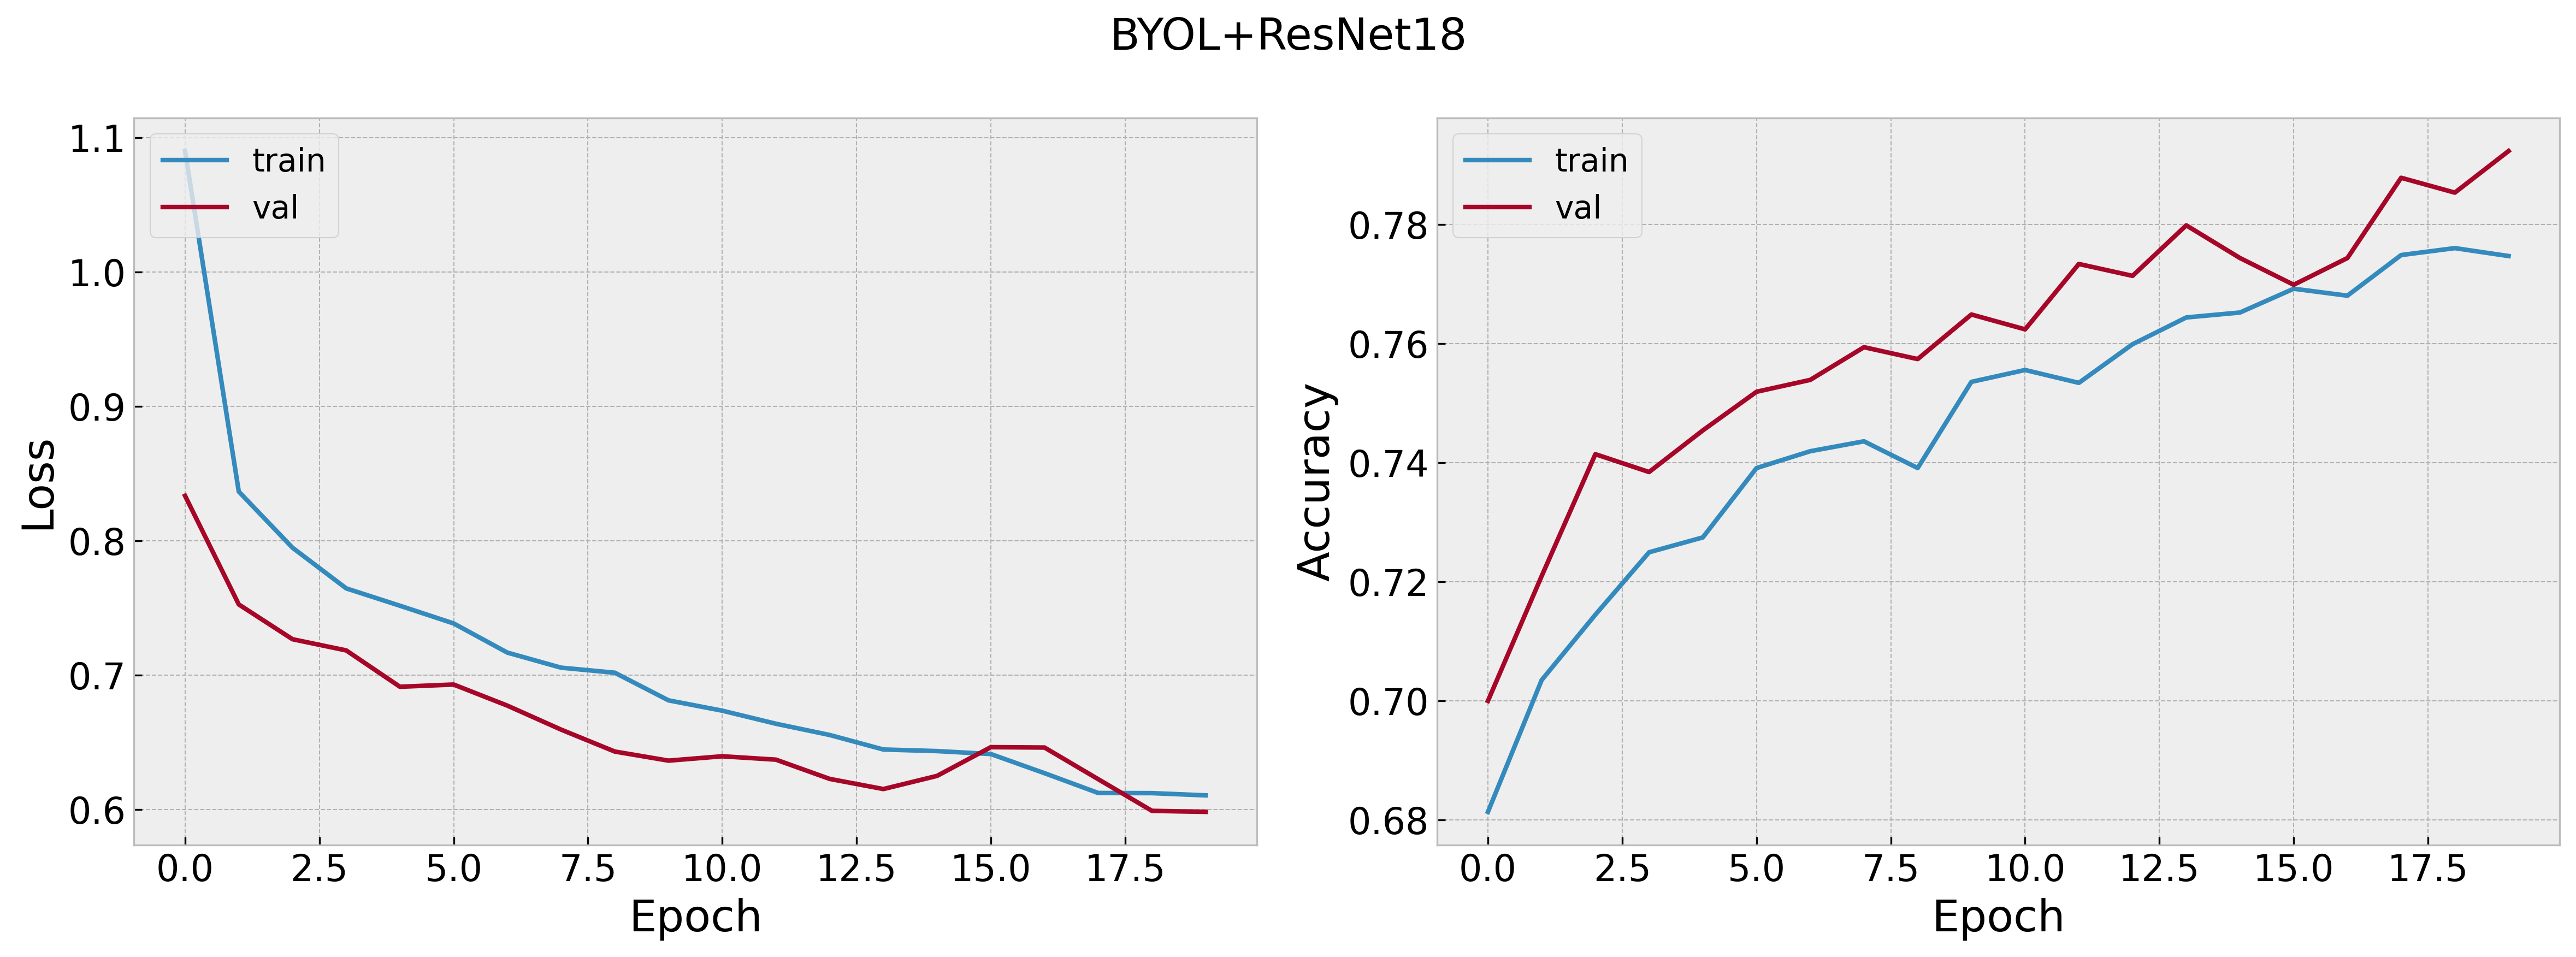

In [ ]:
# ploting
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(train_loss_2, label='train')
_ = plt.plot(val_loss_2, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)

_ = plt.plot(train_acc_2, label='train')
_ = plt.plot(val_acc_2, label='val')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
_ = plt.suptitle("BYOL+ResNet18")
plt.tight_layout()
plt.show()

In [ ]:
test_loss_2, test_acc_2 = test(model_2, test_loader, loss_fn, device)
print(f"Test loss: {test_loss_2:.5f}, Test accuracy: {test_acc_2:.5f}")

Test loss: 0.62570, Test accuracy: 0.77733


In [ ]:
with open('databyolresnet18.txt', 'w') as f:
    f.write("train_loss: {}\n".format(train_loss_2))
    f.write("train_acc: {}\n".format(train_acc_2))
    f.write("val_loss: {}\n".format(val_loss_2))
    f.write("val_acc: {}\n".format(val_acc_2))

407

410

407

409

In [ ]:
torch.save(model_2.state_dict(), 'model_2_fi.pth')

# Performance Comparison

In [ ]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
with open('datavgg16bn.txt', 'r') as f:
    lines = f.readlines()
    train_loss = eval(lines[0].split(": ")[1])
    train_acc = eval(lines[1].split(": ")[1])
    val_loss = eval(lines[2].split(": ")[1])
    val_acc = eval(lines[3].split(": ")[1])

In [ ]:
print(train_loss)
print(train_acc)
print(val_loss)
print(val_acc)

[1.978132788155753, 1.01292078228, 1.0087643872384204, 0.9922014871439535, 0.9768400982029725, 0.9525434238320679, 0.9506592480250337, 0.9442149996459931, 0.9229509850114926, 0.9289137723541514, 0.9013865385065064, 0.8978987094327958, 0.8800237454457853, 0.8616920029746056, 0.8599459961401402, 0.8584867587877522, 0.8492512511104013, 0.8535231875488496, 0.8421122187940426, 0.8375743425295146]
[0.6560159760359461, 0.6748211016808121, 0.6731569312697621, 0.6749875187219171, 0.672990514228657, 0.6769845232151772, 0.6754867698452321, 0.6771509402562822, 0.6779830254618073, 0.6731569312697621, 0.6838076219004826, 0.6869695456814778, 0.6868031286403727, 0.6946247295723083, 0.6886337160925279, 0.692461308037943, 0.6957896488600432, 0.6929605591612581, 0.6949575636545182, 0.6951239806956232]
[0.98195028352666, 0.9576813913082041, 0.9673008933343473, 1.0258167104844862, 0.9184751532045651, 0.9355391056550721, 0.9649175484657764, 0.8968192174085902, 0.9001781819941578, 0.9355371567944676, 0.84458

In [ ]:
train_loss_1, train_acc_1, val_loss_1, val_acc_1 = [], [], [], []
with open('datareset18a1.txt', 'r') as f:
    lines = f.readlines()
    train_loss_1 = eval(lines[0].split(": ")[1])
    train_acc_1 = eval(lines[1].split(": ")[1])
    val_loss_1 = eval(lines[2].split(": ")[1])
    val_acc_1 = eval(lines[3].split(": ")[1])

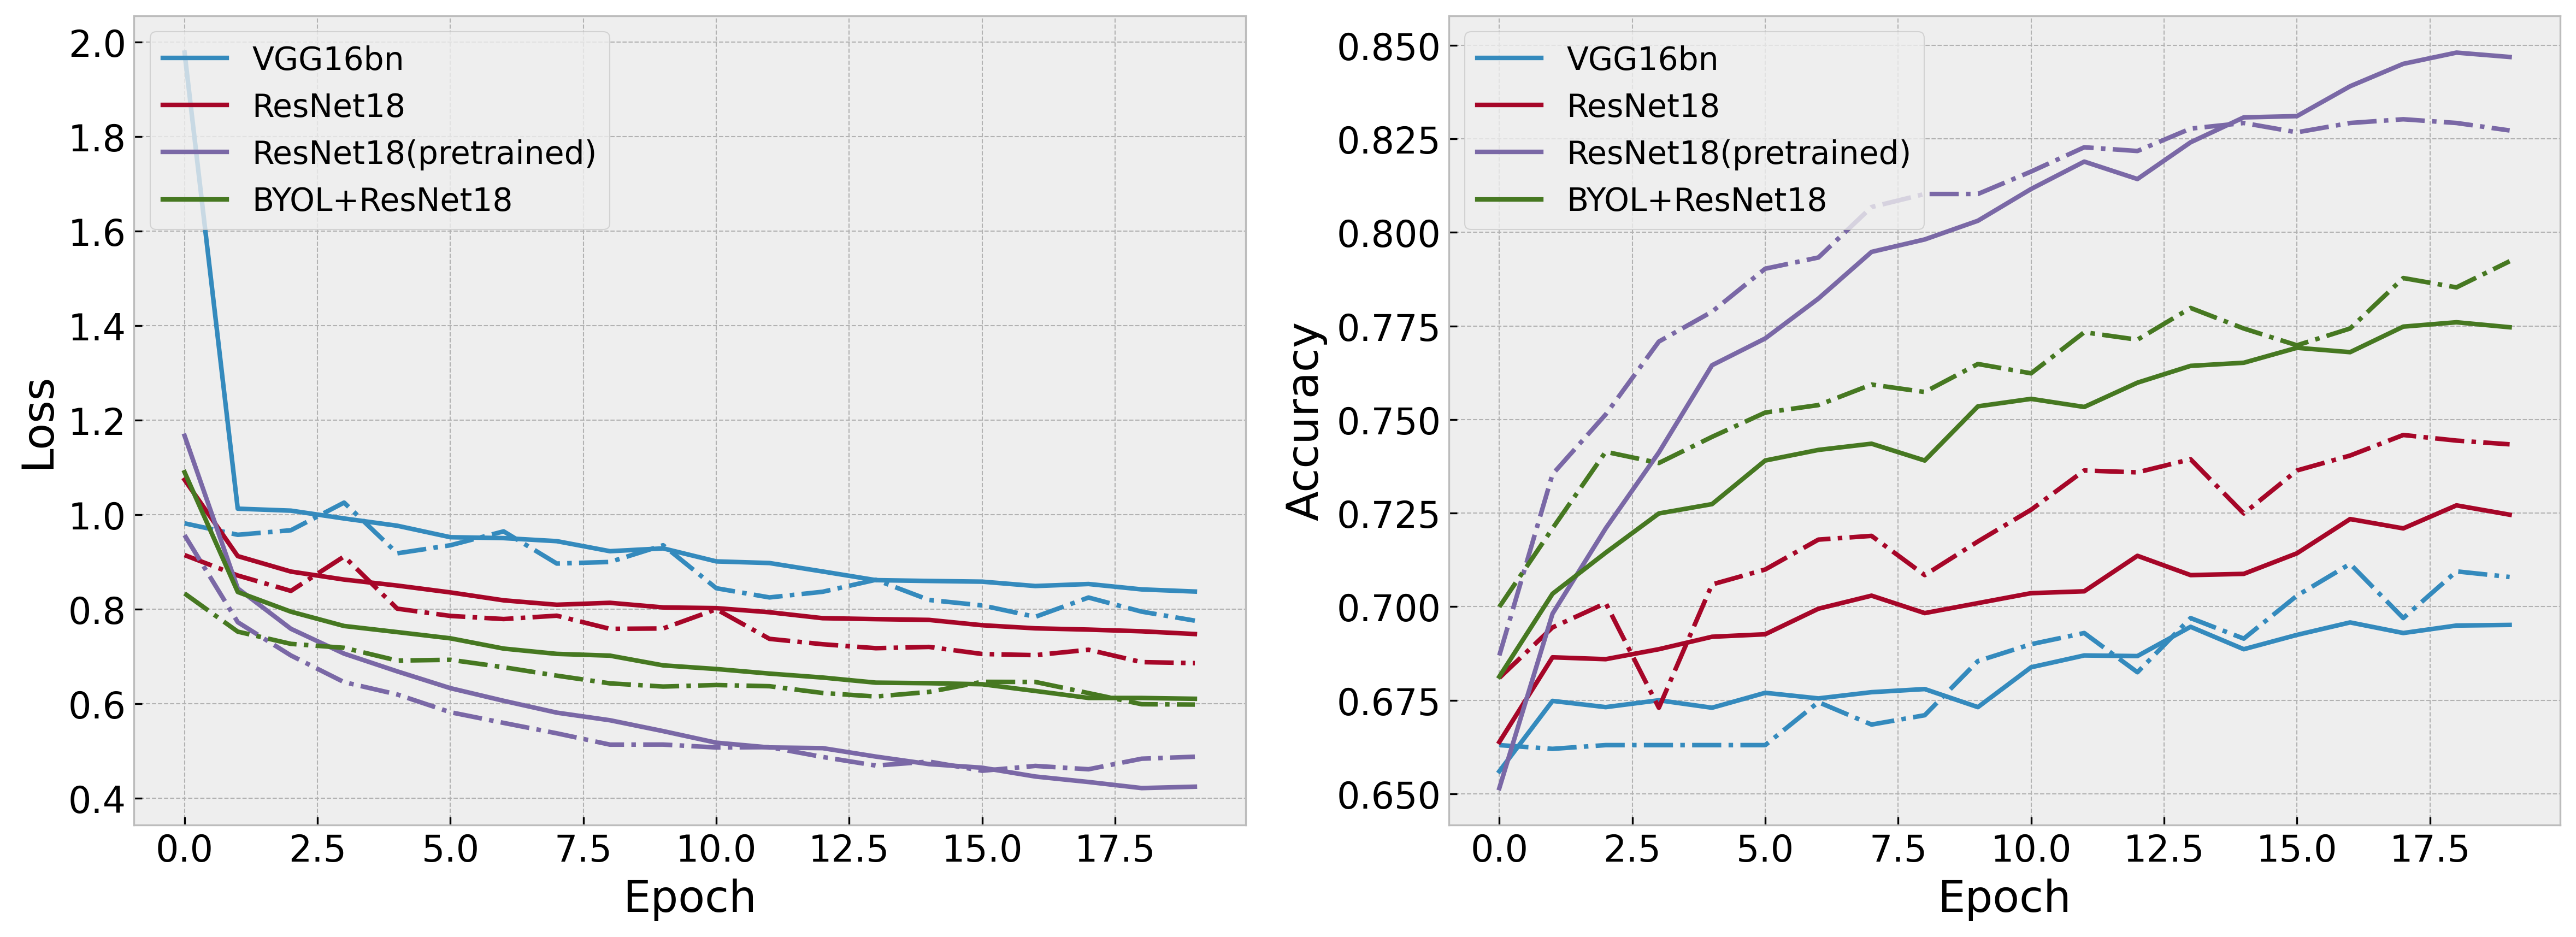

In [ ]:
# ploting
colors = ['#348abd', '#a60628', '#7a68a6', '#467821', '#d55e00', '#cc79a7', '#9ACD32']
_ = plt.subplots(1, 2, figsize=(16, 6))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(train_loss, label='VGG16bn', color=colors[0])
_ = plt.plot(val_loss, '-.', color=colors[0])
_ = plt.plot(train_loss_3, label='ResNet18', color=colors[1])
_ = plt.plot(val_loss_3, '-.', color=colors[1])
_ = plt.plot(train_loss_1, label='ResNet18(pretrained)', color=colors[2])
_ = plt.plot(val_loss_1, '-.', color=colors[2])
_ = plt.plot(train_loss_2, label='BYOL+ResNet18', color=colors[3])
_ = plt.plot(val_loss_2, '-.', color=colors[3])
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()
_ = plt.subplot(1, 2, 2)
_ = plt.plot(train_acc, label='VGG16bn', color=colors[0])
_ = plt.plot(val_acc, '-.', color=colors[0])
_ = plt.plot(train_acc_3, label='ResNet18', color=colors[1])
_ = plt.plot(val_acc_3, '-.', color=colors[1])
_ = plt.plot(train_acc_1, label='ResNet18(pretrained)', color=colors[2])
_ = plt.plot(val_acc_1, '-.', color=colors[2])
_ = plt.plot(train_acc_2, label='BYOL+ResNet18', color=colors[3])
_ = plt.plot(val_acc_2, '-.', color=colors[3])
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend()
plt.tight_layout()
plt.savefig("figs/performance.png", dpi=300)
plt.show()

# t-SNE: Visualizing the Performance of Models in the Feature Space

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
model_1 = timm.create_model(
    'resnet18.a1_in1k',
    pretrained=True,
    num_classes=7,
)

In [ ]:
model_1.load_state_dict(torch.load('model_1.pth'))

<All keys matched successfully>

In [ ]:
model_1 = model_1.to(device)

In [ ]:
model_1.eval()

In [ ]:
label_to_class = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

In [ ]:
features = []
labels = []
for image, label in test_loader:
    image = image.to(device)
    label = label.to(device)
    output = model_1(image)
    features.append(output.detach().cpu().numpy())
    labels.append(label.detach().cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

<Figure size 3000x3000 with 0 Axes>

Text(0.5, 1.0, 'ResNet18(finetune)')

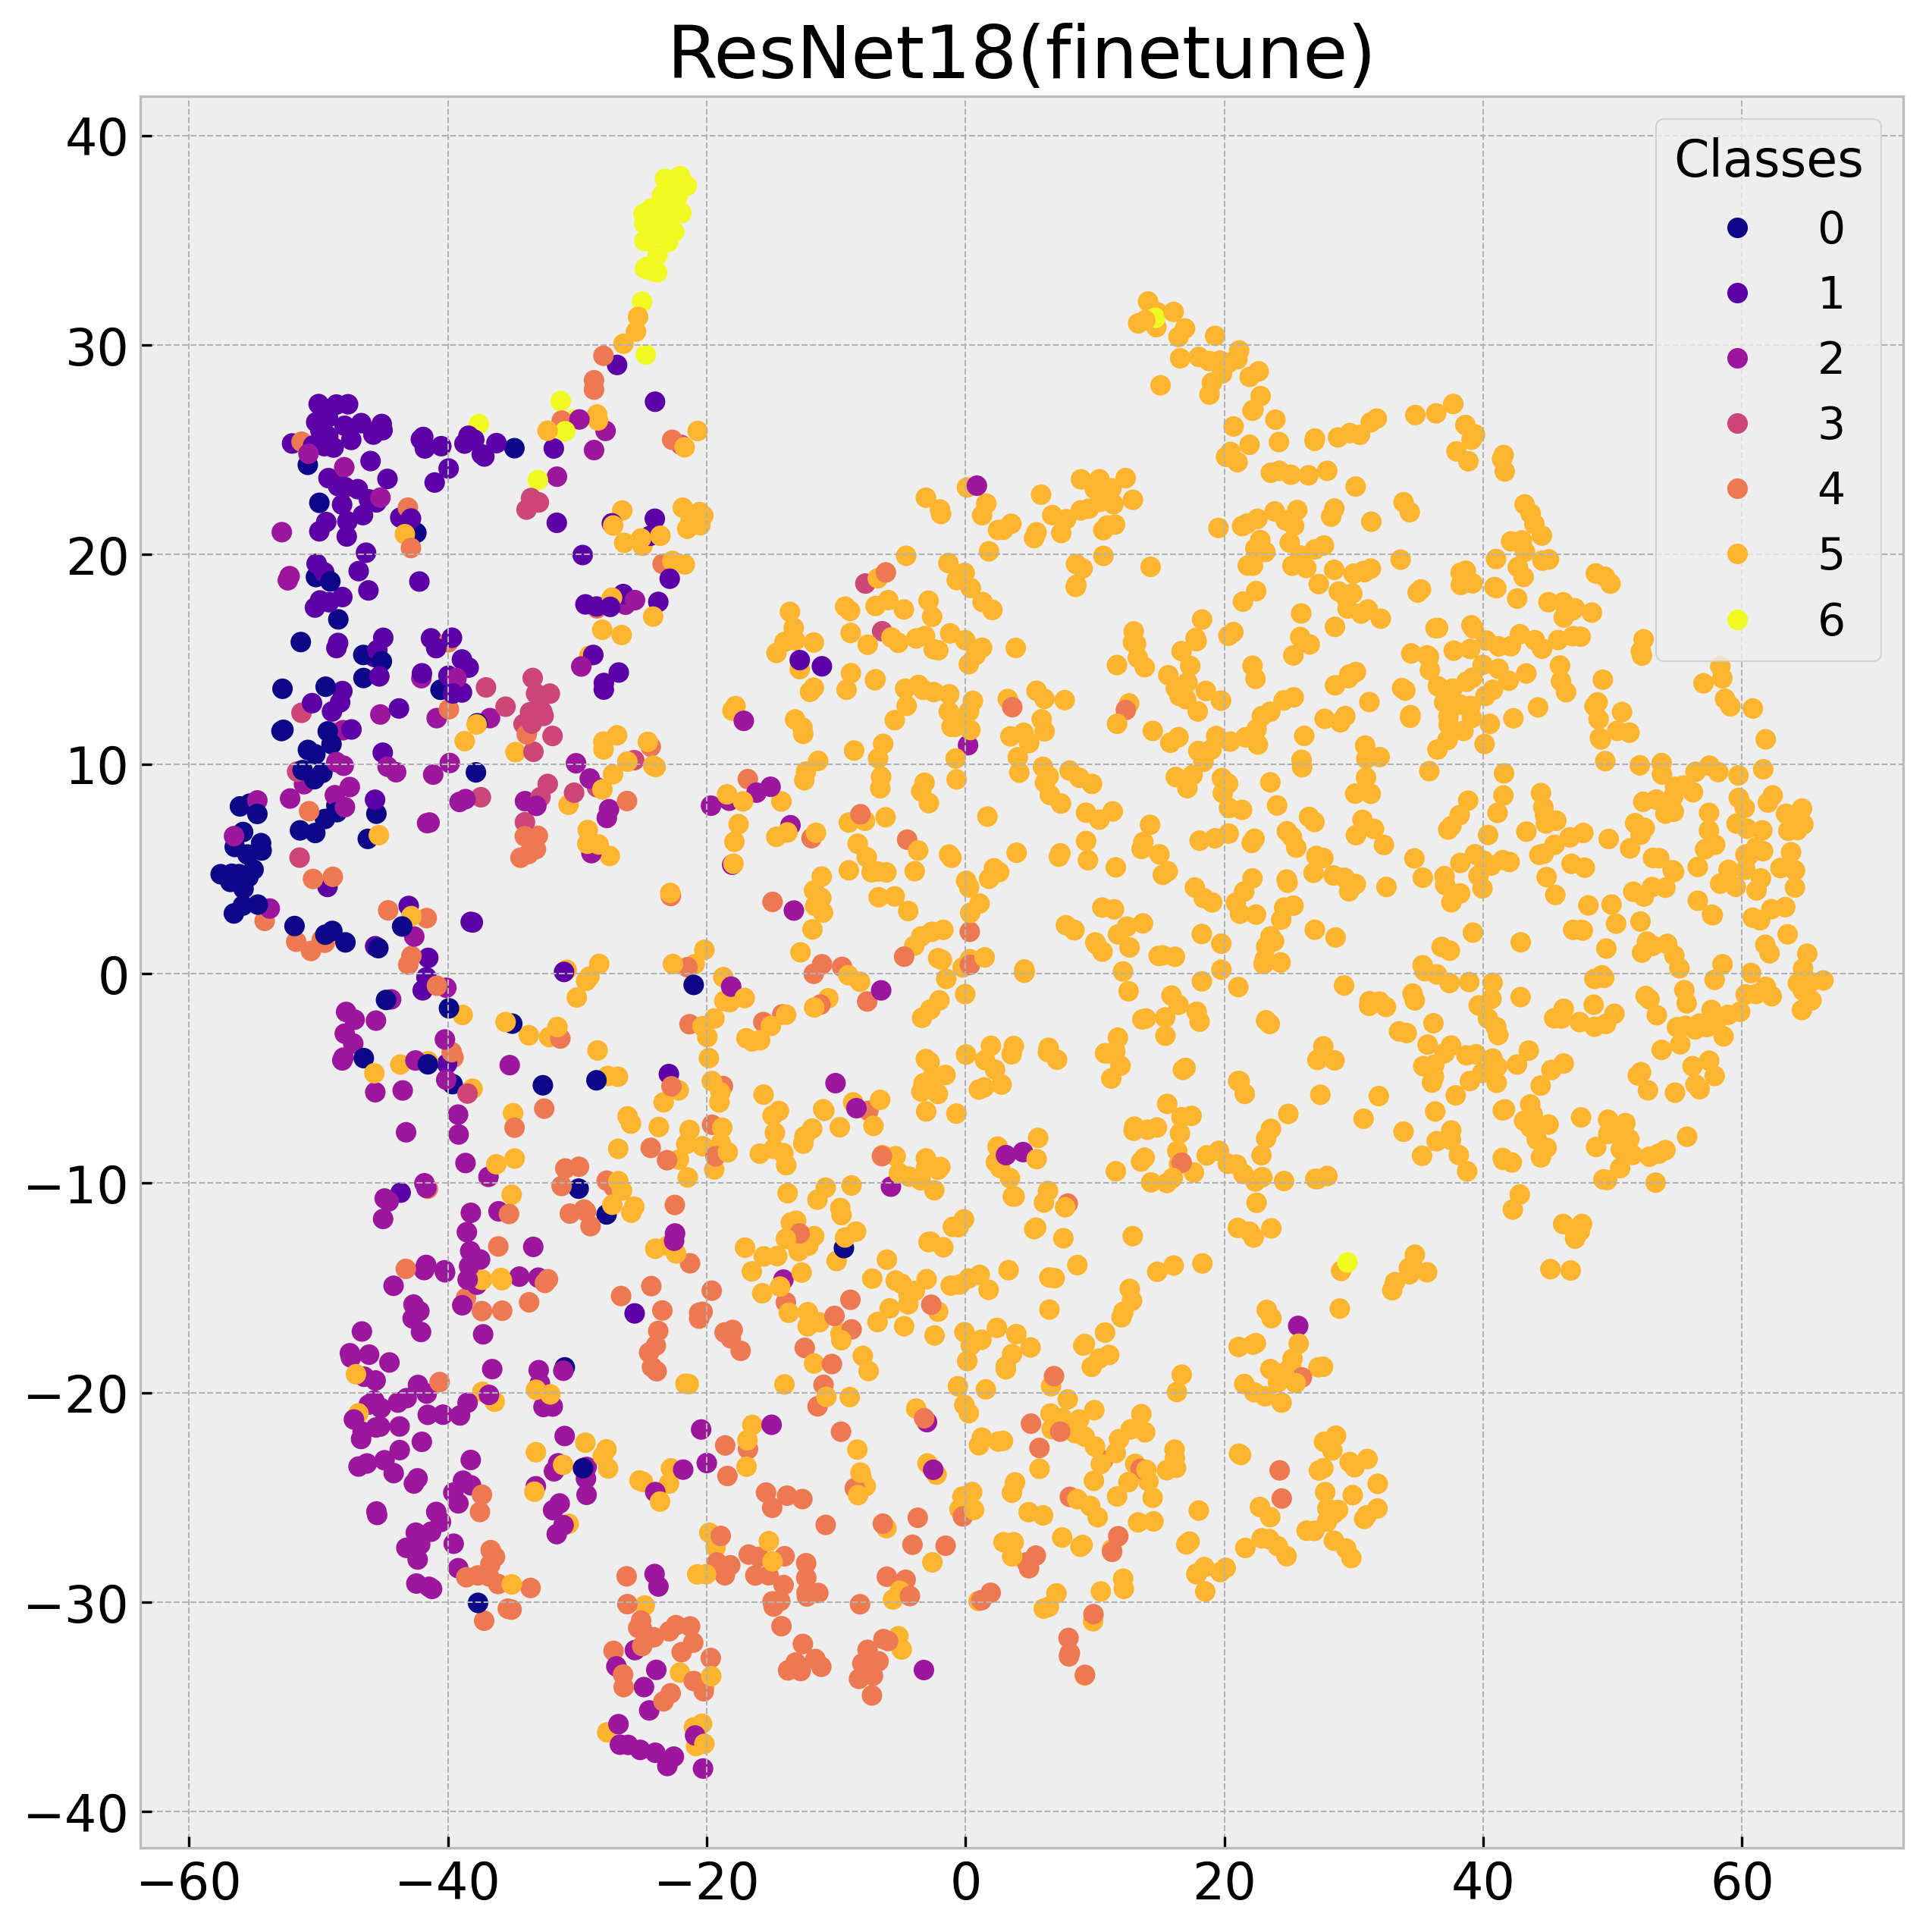

In [ ]:
tsne = TSNE(n_components=2, random_state=1023)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='plasma')

new_labels = [label_to_class[int(label)] for label in labels]
handles, new_labels = scatter.legend_elements()
legend2 = plt.legend(handles, new_labels, loc="upper right", title="Classes")

plt.title("ResNet18(finetune)")
plt.show()

In [ ]:
model = timm.create_model(
    'vgg16_bn.tv_in1k',
    pretrained=False,
    num_classes=7,
)

In [ ]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
model = model.to(device)
model.eval()

In [ ]:
features = []
labels = []
for image, label in test_loader:
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    features.append(output.detach().cpu().numpy())
    labels.append(label.detach().cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

<Figure size 3000x3000 with 0 Axes>

Text(0.5, 1.0, 'VGG16_bn')

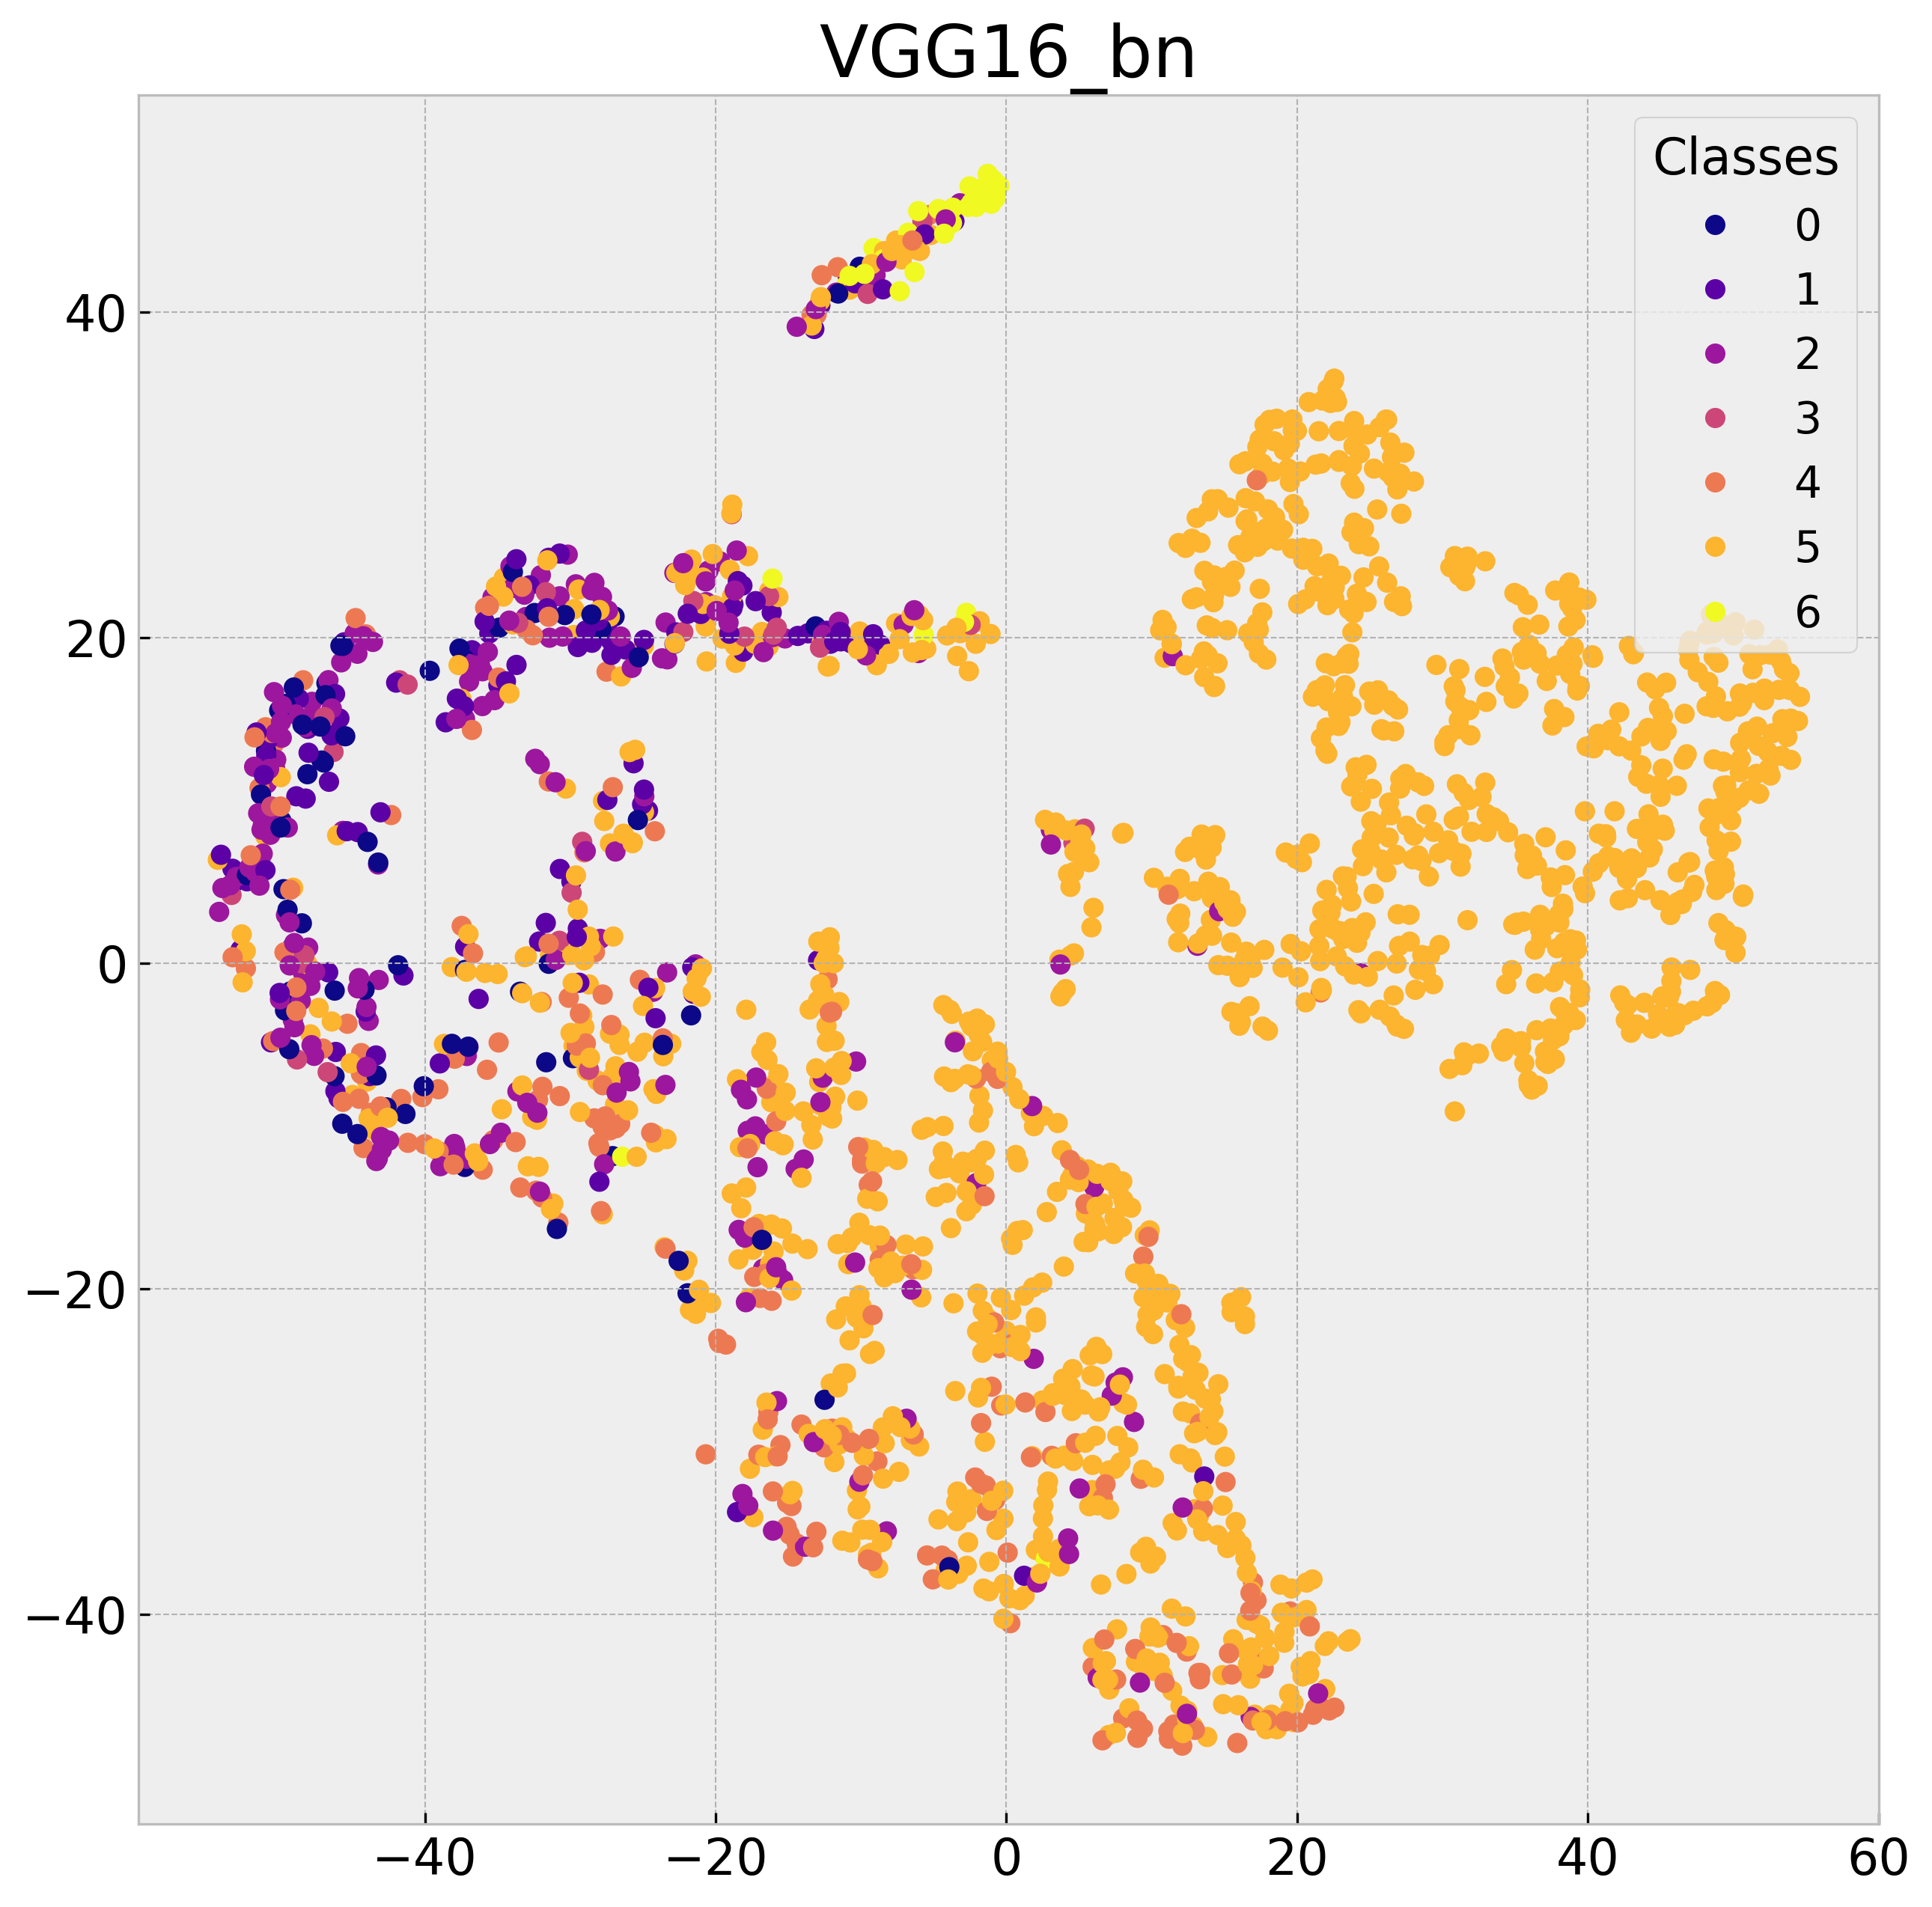

In [ ]:
tsne = TSNE(n_components=2, random_state=1023)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='plasma')

new_labels = [label_to_class[int(label)] for label in labels]
handles, new_labels = scatter.legend_elements()
legend2 = plt.legend(handles, new_labels, loc="upper right", title="Classes")

plt.title("VGG16_bn")
plt.show()

# CVAE (an attempt on 28*28 dataset)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.images = df.iloc[:, :-1].values.astype(np.uint8).reshape(-1, 3, 28, 28)
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
SEED = 1023
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [ ]:
batch_size = 128
learning_rate = 0.005
input_size = 3*28*28
hidden_size = 12
labels_length = 7

In [ ]:
transform_1 = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,),  (0.5,))
])

In [ ]:
df = pd.read_csv('hmnist_28_28_RGB.csv')

In [ ]:
df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
dataset = SkinCancerDataset(df,transform=transform_1)

In [ ]:
dataset[0]

(tensor([[[ 0.5059,  0.3961,  0.3804,  ...,  0.4902,  0.1137,  0.6000],
          [ 0.3255, -0.3098,  0.6078,  ...,  0.4510,  0.5765,  0.5451],
          [ 0.1216,  0.5529,  0.5294,  ...,  0.3412,  0.4588,  0.4431]],
 
         [[ 0.2000,  0.6000,  0.6000,  ...,  0.6471,  0.6627,  0.2392],
          [ 0.3725,  0.5922,  0.2549,  ...,  0.6941,  0.1922,  0.6471],
          [ 0.6706,  0.1922,  0.6392,  ...,  0.0667,  0.6784,  0.6627]],
 
         [[ 0.5137,  0.6863,  0.2000,  ...,  0.6784,  0.2784,  0.4431],
          [ 0.6549,  0.0980,  0.5059,  ...,  0.2549,  0.3725,  0.7412],
          [ 0.2000,  0.3255,  0.7725,  ...,  0.2863,  0.6314,  0.3176]],
 
         ...,
 
         [[ 0.4196,  0.4824,  0.5216,  ..., -0.4196,  0.5216,  0.3020],
          [-0.4196,  0.5451,  0.0510,  ...,  0.5608,  0.5529, -0.0588],
          [ 0.5216,  0.5686, -0.2157,  ...,  0.4667,  0.4980,  0.4510]],
 
         [[ 0.6000,  0.6000,  0.1922,  ...,  0.5529,  0.1216,  0.3412],
          [ 0.3020,  0.1843,  0.0510

In [ ]:
len(dataset[0][0])

28

In [ ]:
total_len = len(dataset)
train_len = int(total_len * 0.8)
val_len = total_len - train_len

train_data, val_data = torch.utils.data.random_split(dataset, [train_len, val_len])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)